<H1> CrystallineMLAlone.ipynb </H1>

This code requires that CrystallineFileLectureTests.ipynb has been run. As the data base is extremely small, the effects of overfitting and underfitting are very prone to happening. To test if a model performs as expected it should try to predict files that have not been used in the process of training and validation. As we can't extract too many files form the data base, the solution is to extract the n-th experiment, train a model with a given structure with all the other experiments, try to predict this isolated experiment (a blind prediction where we know what the output should be) and repeat the process for all experiments. To compare the results of different models please use the code files inside LTestVisualCheck

__________________________________________________________________________________________

OUTPUTS OF THE CODE: 

1. CrystallineLog_Testing_ML.txt
A log file with every step that the algorithm has followed


2. CrystallineExecution_times.txt
It times how long the code took to loop for each model to loop over all the isolation 


3. CrystallineAllTestsFolder_{Complexity}_{num_augmentations} 
For each Complexity and each num_augmentations (a.k.a, for each model structure and data organization) a folder is created. Inside there are folders for each isolated experiment iteration

3.1 Missing{base_name}
For each experiment in the data base (CrystallineMLDataBase) a folder is created and inside there are all the files that the code has created when training and predicting
 
3.1.1 Difference_{base_name}.jpg
For each experimental point, we obtain the prediction and we obtain the difference between prediction and experimental values. It may be helpful to detect an overall deficiency when predicting

3.1.2 Difference_{base_name}.txt
Has the same information as the last .jpg but written on a .txt file

3.1.3 Missing_{base_name}.jpg
This is the important graph. It shows in black the experimental values with their uncertainty, in red the pure ML predictions (without the correction) with the uncertainty bands in a transparent red, in green the final predictions (ML + linear correction) with uncertainty as the green transparent band and in blue the corrected predictions for the time points where experimental values are known

3.1.4 PredictedData_PolarizationD3_Missing{base_name}.txt
The green part of the graph but in a .txt file

3.1.5 PredictedPoints_PolarizationD3_Missing{base_name}.txt
The blue part of the graph but in a .txt file

3.1.6 RawData_PolarizationD3_Missing{base_name}.txt
The black part of the graph but in a .txt file. It is supposed to be a duplicate of the file in CrystallineMLDataBase but it is stored to make sure that the scaling process is being done accurately (if it doesn't fit, be very very careful)

3.1.7 model_PolarizationD3.keras
The model used in this isolated-experiment iteration

3.1.8 scaler_static_PolarizationD3.pkl
The scaler for the static parameters (initial and final polarizations included) used in this isolated-experiment iteration

3.1.9 scaler_time_PolarizationD3.pkl
The scaler for the time evolution used in this isolated-experiment iteration

3.1.10 scaler_y_PolarizationD3.pkl
The scaler for the polarization values used in this isolated-experiment iteration


__________________________________________________________________________________________


Process:

1. Read the {base_name}.txt and {base_name}_Parameters.txt from CrystallineMLDataBase (running CrystallineFileLectureTests.ipynb in its folder is COMPULSARY)

2. Choose to use PolarizationD3 or SoftPolarizationD3 (always use the first one as it is a more natural approach)

3. Choose an experiment to isolate (this process is looped over all experiments so all experiments become the isolated one at one point or another)

4. Scaling. The code needs normalization to work so the parameters (or static vector), the time values and the polarization values need to be normalized. There are many ways to choose the normalization process. Especially since we are going to add the first and last polarization measurement to the static vector. Here is the reasoning:
When this algorythm is used, we will give it the same parameter types and the beginning and final polarization. Therefore the wisest approach is to teach the model with this
exact structure. Therefore it is needed that we extract the initial and final polarization from the files and add it into the parameters. This means that all files contribute 
two points less to the algorythm, hence why two point files are useless for training. If uncertainty is used the parameters will have an uncertainty assigned to each of them. In 
order for the model to avoid treating the uncertainties as independent values (when they are dependent to only one of them) we are removing them entirely. Technically the algorythm 
is able to determine if the parameters are useful and reduce the weight to them. As we have so few points, in case this weighting is not done correctly, I have decided to ignore them
Warning, the outputs are scaled (if you want them raw you will have to undo this scaling). Everything has been taken care of automatically
 Summary of Options
Option	Description
1. Leave as is	First/last points removed from time series, added to static params. No duplication. <- What we are doing
2. Duplicate	First/last points added to static, and remain in the time series. Duplicated info.
3. Perturb	First/last points added to static, and perturbed copies remain in time series.

 Option 1 – Leave as is (No duplication)
    What you do: First and last (time, polarization) points are removed from the time series and used only as static parameters.
    Pros:
        No risk of information leakage from duplication.
        Keeps static and dynamic features clearly separated.
        Avoids overfitting to repeated values.
        Cleanest conceptually.
    Cons:
        You're losing two data points per experiment — which may be relevant if datasets are small.
        Time series now has a gap at beginning and end.
        Might miss important boundary dynamics if those edges are meaningful (e.g. stabilization or edge effects).
 Best if you want a clean and leak-proof setup and you're okay with slightly reduced data volume.
 Option 2 – Duplicate first/last into both static and time series
    What you do: First and last values are added to static vector and remain in the time series.
    Pros:
        You retain all original data points, no loss in dataset size.
        You still have access to boundary behavior through static features.
        Easier to debug/troubleshoot models if you see consistency across static/dynamic behavior.
    Cons:
        Information leakage: same value appears in two places, and each is scaled separately.
        Risk of overfitting, especially if those boundary values dominate or are strongly correlated with labels.
        Can confuse models trained to learn relationships, if they see one value in two places with different scaling.
        Scaling separately can make the model learn inconsistent representations of the same quantity.
 Only choose this if your data is scarce and overfitting isn’t a concern, or if the duplicates are negligible in impact.
 Option 3 – Perturb duplicates
    What you do: First/last are added to static vector, and a slightly altered copy remains in the time series (e.g. polarization adjusted using Gaussian noise via uncertainty, small delta on time).
    Pros:
        Keeps all data points, like Option 2.
        Reduces leakage risk because values are no longer exactly the same.
        Still captures edge dynamics in the time series.
        Adds small noise robustness to the model.
    Cons:
        Still not completely clean — the model may still learn the similarity between static and perturbed values.
        If not carefully tuned, noise could introduce label mismatch or make the data noisier than real measurements.
        Slightly more complex to implement and explain.
        You now have synthetic data in your real dataset, which might affect interpretability.
 This is a clever compromise, especially if:
    You're worried about data size,
    You want to retain edge info,
    And you don’t want outright duplication.
Just make sure the noise scale matches real uncertainty — otherwise you risk corrupting the training signal.
 Final Recommendation
    If you value clean data splits and minimizing information leakage, go with Option 1.
    If you need every datapoint and the duplicates are unlikely to skew things, Option 2 is easier but riskier.
    If you want a smart middle ground with some noise robustness, Option 3 is the most nuanced but effective — just be careful with your noise scale.

That way the static vector (with initial and final points included), the polarizations and the time are scaled independently and the scaler is obtained using all but the isolated experiment (to avoid information leakage)

5. Augment the experiments used for training. Augmentation of experiments is the process by which we use the uncertainty of the points of our experiment to create "fake experiments" which could have been measured. Knowing a measurement with uncertainty can be interpreted statistically as a probability of measuring a value inside the error bars. If we were to measure again the same point it is probable that the result would be different (but inside the uncertainty range). Therefore another experiment where our measurements are slightly different but inside the error margins is as valid as our original one. This way we can create copies of the experiment increasing the number of points the ML algorythm can learn from. 
There is one disadvantage of doing augmentation and that is that if the data is augmented too many times, the algorithm will always overfit (5-10 is said to be ok but better safe than sorry). Augment each experiment by adding Gaussian noise to polarization using uncertainty. Returns combined list of original + augmented experiments.

6. Train the model with all experiments but the isolated one and save the scalers and model. The model uses the uncertainty ONLY during augmentation.

7. Prepare the isolated experiment and obtain the linear correction. As our upmost priority is to obtain a prediction capable of substituting the experimental process, i.e. the ML prediction is not the be-all and end-all, an automatic correction is calculated. The first and final points are known so it makes sense that our final curve needs to pass through those two points. Therefore the pure ML prediction will get a linear curve substracted so that these two points are fitted perfectly. It can be toggled on or off

8. Use the trained model to predict (with or without the correction) and store all the possible important information

9. Return the isolated experiment and repeat the process

10. Repeat the process for all four models currently available (you can add new ones by creating a new one on Define_Complexity and adding it to the list on the 'for Complexity' loop) and the four number of augmentations ["Naif", "Simple", "Average","Complex"], [3,5,7,9]

11. The time it takes is also recorded

In [6]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from pathlib import Path
from tensorflow.keras.layers import Dropout
import shutil
import gc
import numpy as np
import matplotlib.pyplot as plt
import joblib
import time
import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import math
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from pathlib import Path
from tensorflow.keras.layers import Dropout
import shutil
import gc
import numpy as np
import joblib
from pathlib import Path
import sys
import time
def win_long_path(path: str) -> str:
    path = os.path.abspath(path)  # normalize to absolute, resolves ".."
    if os.name == "nt":  # only on Windows
        if not path.startswith("\\\\?\\"):
            path = "\\\\?\\" + path
    return path
"""
When loading a single experiment and Hot-encoding CellID the program won't know it it should encode one or three values. (brings up an error of shape mismatch)
WARNING VERY VERY IMPORTANT, IF A NEW CELL IS ADDED, TWO EXPERIMENTS WITH THAT CELL ARE REQUIRED OR HOT ENCODING WILL BREAK (AND THE PROGRAM WON'T PREDICT WITH ZERO EXAMPLES OF THAT CELL)
"""

"""
THIS IS NOT A MODEL CREATING CODE. IT IS A TESTING CODE. This algorythm trains models with all but one experiment and then tries to predict on this one. If we try to predict on an
experiment that has been used for training or validation the result will most likey just be a memorization of the data. By removing the experiment before training we make sure that
the predictions are made on an experiment that the algorythm has never seen. Using the laptops of the ILL the entire code takes between 11000 seconds to 27000 seconds. If you need 
to run it, leave it overnight. 

Why should I use this code?
Once enough data files are present on the database it might be needed to remove the linear correction or the model will have to be made simpler or more complex. With this code you can 
test yourself if the model is correct or if it needs corrections
"""

"""
1. LOG MESSAGE AND GENERAL VARIABLES
"""
"""
Message logging is done like in FileLecture. Here you cn also toggle if log_messages are shown, if plots are shown, if uncertainty is used for the loss function and to augment the experiments
"""
# You can toggle what model to use here
# model_type = "kerasDrop"
model_type = "Conv1D"

PrintDebug = True #This Bool will determine if all logs should be log_messageed on screen on the Python Notebook. The log writing is always on. If False the code will be faster.
ShowPlot = False #This Bool works the same but with showing on screen the plots (they are always saved even with this variable being False). Reduces program cost if False
LogNoise = False #This Bool allows numerical values in the log. Most of these values are not worth keeping but if you want to see if there are no NaNs or zeros you can turn it on

log_file_path = "CrystallineLog_Testing_ML.txt"
# Initialize log file at the start of the script
with open(log_file_path, 'w', encoding='utf-8') as log_file:
    log_file.write("=== Log started ===\n")

def log_message(message):
    if PrintDebug:
        print(message)
    with open(log_file_path, 'a', encoding='utf-8') as log_file:
        log_file.write(message + "\n")
to_erase = ["CrystallineExecution_times.txt", "CrystallineLog_Testing_ML.txt"]
for item in to_erase:
    path = os.path.abspath(item)  # full path
    if os.path.exists(path):
        try:
            if os.path.isfile(path):
                os.remove(path)
                log_message(f"Deleted file: {path}")
            elif os.path.isdir(path):
                shutil.rmtree(path)
                log_message(f"Deleted folder: {path}")
        except Exception as e:
            log_message(f" Could not delete {path}: {e}")
    else:
        log_message(f"Not found (skipped): {path}")
"""
1. LOAD ALL EXPERIMENTS
"""
"""
Just receives the direction of the folder where all experiments reside, the name of the column that will be used (PolarizationD3 or SoftPolarizationD3) and if it should use uncertainy or not.
Uncertainty will be used in the data to augmentate it (create copies of the experiments with values slightly different using a gaussian interpretation of the uncertainty). However if use_uncertainty is off 
then uncertainties won't be used when fitting or predciting and the outputs won't have uncertainty. 
Pros of uncertainty are better predictions
Cons of uncertainty are slower time and more complex methods (risk of overfitting)
This code will extract all the data and store the information as a tuple of Static_parameters(hot encoded), DeltaTime, Polarization (the column chosen) and a column for uncertainty
"""
def load_all_experiments(data_dir, polarization_column):
    log_message(f"Finding all Array Files...")
    arrays_files = sorted(
        glob.glob(os.path.join(data_dir, "*.txt"))) #Find all files that are .txt
    arrays_files = [f for f in arrays_files if not f.endswith("_Parameters.txt")] #Keep only the Arrays (not the parameters) (we are only working with the names!)

    encoded_experiments = []
    all_static_df = []

    static_columns = ['CellID', 'Pressure', 'LabPolarization', 'LabTime'] #Parameter header

    for arrays_path in arrays_files:
        base = os.path.basename(arrays_path)
        # Build parameters filename by adding _Parameters before .txt
        name_without_ext = os.path.splitext(base)[0]
        parameters_filename = f"{name_without_ext}_Parameters.txt"
        parameters_path = os.path.join(data_dir, parameters_filename)

        # Read parameters file
        try:
            parameters_df = pd.read_csv(parameters_path) #Import the parameter file
            if LogNoise:
                log_message(f"Reading parameters file: {parameters_filename}") #Clutter logging

            # get the second row (actually first data row, index 0) as static data
            static_row = parameters_df.iloc[0][static_columns] #Get the parameter numerical values
            all_static_df.append(static_row)

        except Exception as e:
            log_message(f"Failed to read parameters file: {parameters_filename}, error: {e}")
            continue

    log_message(f"Create combined DataFrame for static parameters...")
    static_df = pd.DataFrame(all_static_df) #Combine all static rows into a Dataframe

    log_message(f"Collected static data:")
    """
    Planned visit to see the polariser cells. To have something Hot enconded means that they are changing strings into binary columns (for example, CellID=A, B or C becomes A==[1,0,0], B==[0,1,0], C==[0,0,1]).
    Eventually we will change it so the CellID is exchanged with more information about the cells but it is not the top priority
    """
    log_message(f"Hot encoding CellID PLACEHOLDER, VISIT TO THE LAB MAY BE NEEDED") 
    categorical_cols = ['CellID']
    static_df = pd.get_dummies(static_df, columns=categorical_cols) #Does the hot encoding
    
    # Now second pass: read arrays and create encoded_experiments with encoded static params
    for i, arrays_path in enumerate(arrays_files):
        base = os.path.basename(arrays_path)
        name_without_ext = os.path.splitext(base)[0]
        parameters_filename = f"{name_without_ext}_Parameters.txt"
        parameters_path = os.path.join(data_dir, parameters_filename)
        # log_message(f"Reading arrays file: {base}") #Clutter log
        arrays_df = pd.read_csv(arrays_path) # Reads the time series data 
    
        static_values = static_df.iloc[i].to_list() #Fetches the static parameters corresponding to this experiment
    
        Deltatime = arrays_df["DeltaTime"].values
        polarization = arrays_df[polarization_column].values #Extracts the time array and the selected polarization column.
        #Save the uncertainty even if it is not used afterwards
        Uncertainty = arrays_df["ErrPolarizationD3"].values
        #if len(Deltatime) > 2:
        encoded_experiments.append((static_values, Deltatime, polarization, Uncertainty))
        # log_message(f"Creating Encoded Experiments (appending parameters, time array, polarization array and uncertainty array)") #Clutter log
    log_message(f"Loaded {len(encoded_experiments)} experiments.")
    return encoded_experiments, static_df.columns.tolist()

"""
2. AUGMENT EXPERIMENTS
"""
"""
Augmentation of experiments is the process by which we use the uncertainty of the points of our experiment to create "fake experiments" which could have been measured
Knowing a measurement with uncertainty can be interpreted estadisticaly as a probability of measuring a value inside the error bars. If we were to measure again the same point
it is propable that the result would be different (but inside the uncertainty range). Therefore another experiment where our measurements are slightly different but inside the 
error margins is as valid as our original one. This way we can create copies of the experiment increasing the number of points the ML algorythm can learn from.
There is one disadvantage of doing augmentation and that is that if the data is augmented too many times, the algorythm will always overfit (5-10 is said to be ok but better safe than sorry)
Augment each experiment by adding Gaussian noise to polarization using uncertainty.
Returns combined list of original + augmented experiments.
"""



def augment_experiments(original_experiments, num_augmentations=5, base_seed=42):
    log_message(f"Augmenting {len(original_experiments)} a number of {num_augmentations} times")
    augmented_experiments = []
    for idx, (static, time, polar, uncertainty) in enumerate(original_experiments):
        for n in range(num_augmentations):
            seed = hash((idx, n, base_seed)) % 2**32
            rng = np.random.default_rng(seed)
            noise = rng.normal(loc=0.0, scale=uncertainty)
            new_polar = polar + noise
            if LogNoise:
                log_message(f"      Augmented experiment {idx} #{n} with seed {seed}")
            augmented_experiments.append((static, time, new_polar, uncertainty))
    log_message(f"Augmented to {len(original_experiments + augmented_experiments)} experiments")
    return original_experiments + augmented_experiments

"""
3. BUILD DATASET (FINAL MODIFICATION TO THE STRUCTURE OF THE DATA)
"""
"""
When this algorythm is used, we will give it the same parameter types and the beginning and final polarization. Therefore the wisest approach is to teach the model with this
exact structure. Therefore it is needed that we extract the initial and final polarization from the files and add it into the parameters. This means that all files contribute 
two points less to the algorythm, hence why two point files are useless for training. If uncertainty is used the parameters will have an uncertainty assigned to each of them. In 
order for the model to avoid treating the uncertainties as independent values (when they are dependent to only one of them) we are removing them entirely. Technically the algorythm 
is able to determine if the parameters are useful and reduce the weight to them. As we have so few points, in case this weighting is not done correctly, I have decided to ignore them
Warning, the outputs are scaled (if you want them raw you will have to undo this scaling). Eveything has been taken care of
 Summary of Options
Option	Description
1. Leave as is	First/last points removed from time series, added to static params. No duplication. <- What we are doing
2. Duplicate	First/last points added to static, and remain in the time series. Duplicated info.
3. Perturb	First/last points added to static, and perturbed copies remain in time series.

 Option 1 – Leave as is (No duplication)
    What you do: First and last (time, polarization) points are removed from the time series and used only as static parameters.
    Pros:
        No risk of information leakage from duplication.
        Keeps static and dynamic features clearly separated.
        Avoids overfitting to repeated values.
        Cleanest conceptually.
    Cons:
        You're losing two data points per experiment — which may be relevant if datasets are small.
        Time series now has a gap at beginning and end.
        Might miss important boundary dynamics if those edges are meaningful (e.g. stabilization or edge effects).
 Best if you want a clean and leak-proof setup and you're okay with slightly reduced data volume.
 Option 2 – Duplicate first/last into both static and time series
    What you do: First and last values are added to static vector and remain in the time series.
    Pros:
        You retain all original data points, no loss in dataset size.
        You still have access to boundary behavior through static features.
        Easier to debug/troubleshoot models if you see consistency across static/dynamic behavior.
    Cons:
        Information leakage: same value appears in two places, and each is scaled separately.
        Risk of overfitting, especially if those boundary values dominate or are strongly correlated with labels.
        Can confuse models trained to learn relationships, if they see one value in two places with different scaling.
        Scaling separately can make the model learn inconsistent representations of the same quantity.
 Only choose this if your data is scarce and overfitting isn’t a concern, or if the duplicates are negligible in impact.
 Option 3 – Perturb duplicates
    What you do: First/last are added to static vector, and a slightly altered copy remains in the time series (e.g. polarization adjusted using Gaussian noise via uncertainty, small delta on time).
    Pros:
        Keeps all data points, like Option 2.
        Reduces leakage risk because values are no longer exactly the same.
        Still captures edge dynamics in the time series.
        Adds small noise robustness to the model.
    Cons:
        Still not completely clean — the model may still learn the similarity between static and perturbed values.
        If not carefully tuned, noise could introduce label mismatch or make the data noisier than real measurements.
        Slightly more complex to implement and explain.
        You now have synthetic data in your real dataset, which might affect interpretability.
 This is a clever compromise, especially if:
    You're worried about data size,
    You want to retain edge info,
    And you don’t want outright duplication.
Just make sure the noise scale matches real uncertainty — otherwise you risk corrupting the training signal.
 Final Recommendation
    If you value clean data splits and minimizing information leakage, go with Option 1.
    If you need every datapoint and the duplicates are unlikely to skew things, Option 2 is easier but riskier.
    If you want a smart middle ground with some noise robustness, Option 3 is the most nuanced but effective — just be careful with your noise scale.
"""
def build_dataset(experiments, mode="PolarizationD3"):

    Xs, Xt, y, u = [], [], [], []
    log_message(f"Starting build_dataset for column {mode} ")
    log_message(f"Number of experiments to process: {len(experiments)} (should be (num_augmentations+1)*(number_of_experiments-1)")
    
    for exp_idx, (static_params, delta_time, polarization, uncertainty) in enumerate(experiments):
        if len(delta_time) < 2:
            log_message(f"Skipping experiment {exp_idx}: too few data points (len={len(delta_time)})")
            continue

        
        if LogNoise:
            log_message(f"      Adding First and Last Polarization (with time) values as static parameters") #Clutter log
        init_idx = 0
        final_idx = -1
        initial_dt, initial_p = delta_time[init_idx], polarization[init_idx]
        final_dt, final_p = delta_time[final_idx], polarization[final_idx]

        static_vector = static_params + [
            initial_dt, initial_p,
            final_dt, final_p
        ]
        if LogNoise:
            log_message(f"      Experiment {exp_idx}: static_vector length={len(static_vector)} (should be 10 (three parameters, CellID hot encoded creates three posibilities, four for the initial and final polarization) ") #Clutter log
        if LogNoise:
            log_message(f"      Building samples Static+time+polarization") #Clutter log
        
        #Ignoring first and last points, creates the four arrays of experiments. The n-th component of these lists will have, respectively, the static-vector of the n-th experiment,
        #the whole time list of the n-th experiment, the whole polarization column (chosen with the mode) and the entire uncertainty array.
        for t, p, err in zip(delta_time[1:-1], polarization[1:-1], uncertainty[1:-1]): 
            Xs.append(static_vector)
            Xt.append([t])
            y.append(p)
            u.append(err) #We will ignore always uncertainty in parameters and even if they are not used, we will keep uncertainties in the data sets(same dimensions everywhere)

    log_message(f"Number of experiments processed for mode '{mode}': {len(experiments)}")
    log_message(f"Final dataset shapes: Xs: {np.array(Xs).shape}, Xt: {np.array(Xt).shape}, y: {np.array(y).reshape(-1, 1).shape}")
    return np.array(Xs), np.array(Xt), np.array(y).reshape(-1, 1), np.array(u).reshape(-1, 1)


"""
5. LOSS FUNCTION
"""
"""
ML algorythms require a way to tell the algorythm if it is learning or not. The most standard practice is with a Loss function. If the loss value goes down that means that the
algorythm is learning and if a step it does increases loss then it is punished and tries other things. When using uncertainties when teaching the model, the most common loss 
function is the NLL or Negative log-likelihood of a normal distribution NLL=\frac{1}{2}log(σ^2)+\frac{(y−μ)^2}{2σ^2}. Instead of predicting σ^2 we obtain its logarythm to 
have a more stable process.
"""
def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0:1]
    log_var = y_pred[:, 1:2]
    precision = K.exp(-log_var)
    return K.mean(0.5 * (log_var + K.square(y_true - mu) * precision))




"""
6. MODEL ARCHITECTURE
"""
"""
Keras with tensorflow and only dense layers has proven to be too complex for a data base of less than 1000 points. After converting the experiments with build_database, only ~720 points are used for
training and validation. Therefore I have implemented a if-toggle to switch from different types of models. The only model-type dependent parts of the whole pipeline are the
building of the model, the predictions with the model and fitting with the model. Functions have been created for all of them so that (despite being functions with one line of code
only) it is easier to toggle from one model to the other.

build_model builds the model (obviously)
model_fitting will learn from the input targets nad predict and validates (compares) with the target values (y_values in keras) (changing the weights using backpropagation).
Model predicting won't train or validate, it will just predict. NOrmally only requests the parameters and the times where we will predict. You must imput the model (it is not created in situ)
"""

model_type = "Conv1D"
"""
Using Conv1D we emphasize more on the time evolution of the data. This is really good in our case as we don't need abstract connections (with dense layers) and we are more
interested on dependencies with time. There is no model that is better than the rest. If the model is too complex, overfitting will occur and we will have a useless model. If 
it is complex but not too much then the algoryhtm will start finding patterns that may or may not have real meaning (like oscillations). We truly don't have a good way to 
say if these structures are spurious or not. However if the model is too simple it will just output linear predictions. Given the structure and scale of our patterns this
predictions are not necessarily bad but they are not the best. The real prove that is works will be tring to correct the real data
"""
def Define_Complexity(Complexity):
    from tensorflow.keras import Input, Model, regularizers
    from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Dropout, Concatenate
    from tensorflow.keras.optimizers import Adam

    if Complexity == "Average":       
        def build_model(input_dim_static, use_uncertainty=False):
            static_input = Input(shape=(input_dim_static,), name="static_input")
            time_input = Input(shape=(None, 1), name="time_input")

            x_time = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(time_input)
            x_time = GlobalAveragePooling1D()(x_time)

            x = Concatenate()([static_input, x_time])
            x = Dense(8, activation='tanh')(x)

            mu = Dense(1)(x)
            log_var = Dense(1)(x)
            output = Concatenate()([mu, log_var])

            model = Model(inputs=[static_input, time_input], outputs=output)
            model.compile(optimizer=Adam(), loss=nll_loss if use_uncertainty else 'mse')
            return model

    elif Complexity == "Complex":
        def build_model(input_dim_static, use_uncertainty=False):
            static_input = Input(shape=(input_dim_static,), name="static_input")
            time_input = Input(shape=(None, 1), name="time_input")

            x_time = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(time_input)
            x_time = Dropout(0.3)(x_time)
            x_time = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x_time)
            x_time = Dropout(0.3)(x_time)
            x_time = GlobalAveragePooling1D()(x_time)

            x = Concatenate()([static_input, x_time])
            x = Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(1e-3))(x)
            x = Dropout(0.3)(x)
            x = Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(1e-4))(x)
            x = Dropout(0.2)(x)
            x = Dense(16, activation='tanh')(x)

            mu = Dense(1)(x)
            log_var = Dense(1)(x)
            output = Concatenate()([mu, log_var])

            model = Model(inputs=[static_input, time_input], outputs=output)
            model.compile(optimizer=Adam(), loss=nll_loss if use_uncertainty else 'mse')
            return model

    elif Complexity == "Simple":
        def build_model(input_dim_static, use_uncertainty=False):
            static_input = Input(shape=(input_dim_static,), name="static_input")
            time_input = Input(shape=(None, 1), name="time_input")

            x_time = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(time_input)
            x_time = Dropout(0.3)(x_time)
            x_time = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x_time)
            x_time = GlobalAveragePooling1D()(x_time)

            x = Concatenate()([static_input, x_time])
            x = Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(1e-3))(x)
            x = Dropout(0.2)(x)
            x = Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(1e-2))(x)

            mu = Dense(1)(x)
            log_var = Dense(1)(x)
            output = Concatenate()([mu, log_var])

            model = Model(inputs=[static_input, time_input], outputs=output)
            model.compile(optimizer=Adam(), loss=nll_loss if use_uncertainty else 'mse')
            return model

    elif Complexity == "Naif":
        def build_model(input_dim_static, use_uncertainty=False):
            static_input = Input(shape=(input_dim_static,), name="static_input")
            time_input = Input(shape=(None, 1), name="time_input")

            x_time = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(time_input)
            x_time = GlobalAveragePooling1D()(x_time)

            x = Concatenate()([static_input, x_time])
            x = Dense(8, activation='relu')(x)

            mu = Dense(1)(x)
            if use_uncertainty:
                log_var = Dense(1)(x)
                output = Concatenate()([mu, log_var])
            else:
                output = mu

            model = Model(inputs=[static_input, time_input], outputs=output)
            model.compile(optimizer=Adam(), loss=nll_loss if use_uncertainty else 'mse')
            return model

    log_message(f"Built model {Complexity}")
    return build_model  # <--- IMPORTANT

                
          
        
def model_fitting(model, X_static_scaled, X_time_scaled, y_scaled, epochs, batch_size, verbose, callbacks=None):
    log_message(f"Training the model...")
    return model.fit(
        [X_static_scaled, X_time_scaled],
        y_scaled,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=callbacks
    )
def model_prediction(model, X_static_scaled, X_time_scaled):
    log_message(f"Predicting {len(X_time_scaled)} time points")
    return model.predict([X_static_scaled, X_time_scaled], verbose=0)
        
"""
7. PLOT EXPERIMENTS 
"""
"""
This function is currently not being used
Just a quick check to see if there is no underfitting. The bare minimum the ML algorythm should be able to do is to predict the data points it learned from training and validation
There is no differnece when plotting if uncertainty is on or off, the changes are only on the model that is being imported
Will plot the experiments you give it (if you only give one, it will only do one, if you give it all but one, then all but one will be plotted)


def plot_experiments(encoded_experiments, scaler_static, scaler_time, scaler_y, model_type, model, output_folder, base_name, use_uncertainty=False, mode='PolarizationD3', N_offset=0.0):
    log_message(f"Begin Plotting...")
    total_exps = len(encoded_experiments)
    colors = plt.colormaps.get_cmap('tab20').resampled(total_exps)



    for exp_idx, exp in enumerate(encoded_experiments):
        static_params, delta_time, true_polar, real_uncertainty = exp
        initial_dt, initial_p = delta_time[0], true_polar[0]
        final_dt, final_p = delta_time[-1], true_polar[-1]
        static_vector = static_params + [initial_dt, initial_p, final_dt, final_p]


        color = colors(exp_idx)
        grid_times = np.arange(0, max(delta_time) + 1000, 1000)
        static_array = np.tile(static_vector, (len(grid_times), 1))
        time_array = grid_times.reshape(-1, 1)
    
        static_scaled = scaler_static.transform(static_array)
        time_scaled = scaler_time.transform(time_array)
    
        if model_type == 'kerasDrop':
            pred_scaled = model_prediction(model, static_scaled, time_scaled)
        if model_type == 'Conv1D':
            pred_scaled = model_prediction(model, static_scaled, time_scaled)
            
        mu_pred = scaler_y.inverse_transform(pred_scaled[:, 0:1])
        mu_pred -= N_offset #Correction in the y-axis

        sigma = np.sqrt(np.exp(pred_scaled[:, 1:2])) * (mu_pred + 1e-6)
    
        # Common suffix and base name
        suffix = "_uncertainty" if use_uncertainty else "_no_uncertainty"
        base_title = f"Experiment {exp_idx + 1}, column={mode}, {base_name}"
    
        def make_plot(tight=False):
            fig, ax = plt.subplots(figsize=(8, 5)) 
            title = f"Experiment_{exp_idx + 1}{suffix}_{mode}_Missing{base_name}.png" + (" — tight" if tight else "")
            ax.set_title(title)
            ax.grid(True)
    
            ax.scatter(delta_time, true_polar, color=color, marker='o', s=40, label="True")
            ax.errorbar(delta_time, true_polar, yerr=real_uncertainty, fmt='none',
                        ecolor=color, alpha=0.6, capsize=3, label="Real ±σ")
            ax.scatter(grid_times, mu_pred, color=color, marker='x', s=40, label="Pred Points")
            ax.plot(grid_times, mu_pred, '--', color=color, alpha=0.7, label="Pred Line")
            ax.fill_between(grid_times, (mu_pred - sigma).flatten(), (mu_pred + sigma).flatten(),
                            color=color, alpha=0.2, label="Predicted ±1σ")
    
            if tight:
                y_min = min(np.min(true_polar), np.min(mu_pred))-0.05
                y_max = max(np.max(true_polar), np.max(mu_pred))+0.05
                ax.set_ylim([y_min, y_max])
    
            ax.legend()
            fig.tight_layout()
    
            # Save figure
            tight_str = "_tight" if tight else ""
            fig_filename = f"Experiment_{exp_idx + 1}{suffix}_{mode}{tight_str}_Missing{base_name}.png"
            fig_path = output_folder / fig_filename
            log_message(f"Saved figure to: {fig_path}")
            fig.savefig(fig_path.with_suffix(".jpg"), dpi=100)
            plt.close(fig)
            del fig, ax
            gc.collect()
    
        # Create both plots
        make_plot(tight=False)  # original
        make_plot(tight=True)   # tight version
        # === Write RawData.txt ===
        raw_data_path = output_folder / f"RawData_{mode}_Missing{base_name}.txt"
        with open(raw_data_path, 'w') as f:
            f.write(f"DeltaTime\tRealPolarizationD3\tErrRealPolarizationD3\n")
            for t, p, e in zip(delta_time, true_polar, real_uncertainty):
                f.write(f"{t:.6f}\t{p:.6f}\t{e:.6f}\n")
        log_message(f"Saved raw data to: {raw_data_path}")

        # === Write PredictedData.txt ===
        predicted_data_path = output_folder / f"PredictedData_{mode}_Missing{base_name}.txt"
        with open(predicted_data_path, 'w') as f:
            f.write(f"GridTime\tPredictedPolarizationD3\tErrPredictedPolarizationD3\n")
            for t, p, s in zip(grid_times, mu_pred.flatten(), sigma.flatten()):
                f.write(f"{t:.6f}\t{p:.6f}\t{s:.6f}\n")
        log_message(f"Saved predicted data to: {predicted_data_path}")
"""


"""
The same as train_and_plot but without plotting
"""
def train(encoded_experiments, scaler_static, scaler_time, scaler_y, model_type, use_uncertainty, mode):
    log_message(f"Begin training and scaling with {len(encoded_experiments)} experiments.")
    X_static_all, X_time_all, y_all, u_all = build_dataset(encoded_experiments)


    log_message(f"Scaling all data")
    X_static_scaled = scaler_static.fit_transform(X_static_all)
    X_time_scaled = scaler_time.fit_transform(X_time_all)
    y_scaled = scaler_y.fit_transform(y_all)
    
    model = build_model(X_static_all.shape[1], use_uncertainty=use_uncertainty)
    epochs = 300
    batch_size = 32
    log_message(f"Training final model with epochs={epochs}, batch_size={batch_size} and use_uncertainty = {use_uncertainty}")
    model_fitting(model, X_static_scaled, X_time_scaled, y_scaled, epochs, batch_size, verbose=0)

    return model
"""

9. BUILD DATASET INCLUDING THE INITIAL AND FINAL POLARIZATION POINTS
"""
"""
Currently unused, does the same as build_dataset but doesn't extract the initial and final polarization to send them to the static vector. This way those values are scaled
as regular polarization points and regular time points. Afterwards it adds them to the static parameters. Unused because we are scaling those four values as static parameters
in the final build. (Will erase when project is finished)
"""
def build_dataset_including_edges(experiments, mode="PolarizationD3"):
    Xs, Xt, y, u = [], [], [], []
    log_message(f"      Starting build_dataset_including_edges for column {mode} ")
    log_message(f"      Number of experiments to process: {len(experiments)}")
    for exp_idx, (static_params, delta_time, polarization, uncertainty) in enumerate(experiments):
        if len(delta_time) < 1:
            log_message(f"            Skipping experiment {exp_idx}: too few data points (len={len(delta_time)})")
            continue

        for t, p, err in zip(delta_time, polarization, uncertainty):
            static_vector = static_params + [delta_time[0], polarization[0], delta_time[-1], polarization[-1]]
            if LogNoise:
                log_message(f"      Adding First and Last Polarization (with time) values as static parameters")
            Xs.append(static_vector)
            Xt.append([t])
            y.append(p)
            u.append(err)
        if LogNoise:
            log_message(f"      Experiment {exp_idx}: static_vector length={len(static_vector)} (should be 10 (three parameters, CellID hot encoded creates three posibilities, four for the initial and final polarization) ")
        if LogNoise:
            log_message(f"      Building samples Static+time+polarization")
        log_message(f"Number of experiments processed for mode '{mode}': {len(experiments)}")
        log_message(f"Final dataset shapes: Xs: {np.array(Xs).shape}, Xt: {np.array(Xt).shape}, y: {np.array(y).reshape(-1, 1).shape}")
    return np.array(Xs), np.array(Xt), np.array(y).reshape(-1, 1), np.array(u).reshape(-1, 1)


from numpy import array

def align_static_vectors(experiments, static_columns_training, static_columns_isolated):
    aligned_experiments = []
    for static, delta_time, polarization, uncertainty in experiments:
        static_dict = dict(zip(static_columns_isolated, static))
        aligned_static = [static_dict.get(col, 0.0) for col in static_columns_training]
        aligned_experiments.append((aligned_static, delta_time, polarization, uncertainty))
    return aligned_experiments


"""
10. MODEL PREDICTIONS WITH FORCED INITIAL AND FINAL POLARIZATION PREDICTIONS
"""
"""
Some models don't predict the overall shape correctly. They find plateaus, abrupt slope changes but they have (normally) an overall slope that is not as steep as it should be. As a 
'discount' solution we can correct the predictions substracting a linear curve. The only points that we can use to correct the data are the first and final polarization values.
By substracting the correct curve we can force the prediction for the initial and final point to be the experimental values. 
Is this method 'legal'? I don't know but at least we have something that makes sense and in a hurry you can get a better estimate. 

"""
def model_predict_corrected(model, X_static_scaled, X_time_scaled, m, n, scaler_y, scaler_time):
    log_message(f"Correcting {len(X_time_scaled)} by subtracting P(t) = {float(np.squeeze(m)):.3e} * t + {float(np.squeeze(n)):.3e}")
    # Step 1: Get scaled predictions from model
    # y_pred_scaled shape: (N, 2) --> columns: [mean_scaled, log_var_scaled]
    y_pred_scaled = model_prediction(model, X_static_scaled, X_time_scaled)
    
    # Step 2: Inverse transform only the mean predictions to real units
    mean_scaled = y_pred_scaled[:, 0:1]  # shape (N,1)
    mean_real = scaler_y.inverse_transform(mean_scaled)  # shape (N,1)
    
    # Step 3: Inverse transform times to real units (for correction)
    time_real = scaler_time.inverse_transform(X_time_scaled)  # shape (N,1)
    
    # Step 4: Calculate correction curve in real units
    correction = m * time_real + n  # shape (N,1)
    
    # Step 5: Apply correction to mean predictions (real units)
    mean_corrected_real = mean_real - correction  # shape (N,1)
    
    # Step 6: Scale corrected mean predictions back to scaled space
    mean_corrected_scaled = scaler_y.transform(mean_corrected_real)  # shape (N,1)
    
    # Step 7: Keep log variance as is (no correction applied, shape (N,1))
    log_var_scaled = y_pred_scaled[:, 1:2]  # shape (N,1)
    
    # Step 8: Recombine corrected mean and original log variance
    y_pred_corrected_scaled = np.hstack([mean_corrected_scaled, log_var_scaled])  # shape (N,2)
    
    return y_pred_corrected_scaled





"""
11. MAIN CODE FUNCTION
"""
"""
Extract one file, send to Isolated folder train with the rest, predict on the isolated one and repeat for all. Requires the model type, the direction with the data files. an outut folder
name (to create the subfolders of each experiment in it), the number of augmentations to train the model with and finally a bool (Correction) to force the initial and final polarization
predictions to be the measured values
"""
def isolate_experiments(data_dir,isolated_dir, model_type, output_folder, use_uncertainty, num_augmentations, Correction, build_model):
    data_dir = Path(data_dir)
    isolated_dir = Path(isolated_dir)
    output_folder = Path(output_folder)

    #1. Prepare the folder where the isolated experiments will reside
    isolated_dir = data_dir.parent / "CrystallineMLIsolatedExperiment"
    isolated_dir.mkdir(exist_ok=True)

    # Get all *_Parameters.txt files to derive base names
    param_files = list(data_dir.glob("*_Parameters.txt"))
    base_names = [f.stem.replace("_Parameters", "") for f in param_files]
    for base_name in base_names:
        file_param = data_dir / f"{base_name}_Parameters.txt"
        file_data = data_dir / f"{base_name}.txt"

        if not (file_param.exists() and file_data.exists()):
            log_message(f"Skipping {base_name}: One of the required files does not exist.")
            continue

        # 3. Move both files to isolated folder
        shutil.move(win_long_path(str(file_param)), win_long_path(str(isolated_dir / file_param.name)))
        shutil.move(win_long_path(str(file_data)), win_long_path(str(isolated_dir / file_data.name)))

        log_message(f"Successfully sent {base_name} to {isolated_dir}")

        # 4. Create subfolder for this experiment
        output_subfolder = output_folder / f"Missing{base_name}"
        output_subfolder.mkdir(exist_ok=True)
        log_message(f"Created folder: {output_subfolder}")

        # 5. Train and predict using both modes
        for mode in ["PolarizationD3"]: 
            log_message(f"\n=== Processing mode: {mode} (excluding {base_name}) ===\n")

            # 6. Load all experiments and augment them
            experiments, static_columns = load_all_experiments(str(data_dir), polarization_column=mode)
            encoded_experiments = augment_experiments(experiments, num_augmentations, base_seed=42)

            
            #7. Scalers. All polarization and time values are scaled using all the experiments (except the isolated one). The reason for excluding them is to avoid information
            #leackage. The static parameters are scaled afterwards but they are also scaled with all but one experiments
            log_message(f"Scale all experiments (except the isolated one)")
            all_time = []
            all_y = []
            
            for static, time, pol, _ in encoded_experiments:
                all_time.append(time)
                all_y.append(pol)
            
            all_time = np.concatenate(all_time).reshape(-1, 1) #unscaled
            all_y = np.concatenate(all_y).reshape(-1, 1) #unscaled
            
            scaler_time = MinMaxScaler().fit(all_time) #fit to all
            scaler_y = MinMaxScaler().fit(all_y) #fit to all
            
            #8. Prepare all the experiments so that they can be introduced in the training functions
            X_static_raw, X_time_raw, y_raw, u = build_dataset(encoded_experiments, mode=mode)
            """ One might think to scale the polarization values using the polarization scaler and to scale the time values with the time scaler. However this comes with the
            problem of having to juggle three scalers at once when working with the static vector. This proved to be difficult and showed no real improvement. If you scale those
            values and then scale the entire vector (as it needs scaling) then you have values scaled twice that lose any links with the time and polarization scales. Therefore
            it has been decided to just scale the entire vector using only the other static vectors"""
            scaler_static = MinMaxScaler().fit(X_static_raw) #fit to all

            if LogNoise:
                log_message(f"      Scaler static min_: , {scaler_static.min_}")
                log_message(f"      Scaler static scale_: , {scaler_static.scale_}")
                log_message(f"      Scaler static data_min_: , {scaler_static.data_min_}")
                log_message(f"      Scaler static data_max_: , {scaler_static.data_max_}")
                
                log_message(f"      Scaler time min_: , {scaler_time.min_}")
                log_message(f"      Scaler time scale_: , {scaler_time.scale_}")
                log_message(f"      Scaler time data_min_: , {scaler_time.data_min_}")
                log_message(f"      Scaler time data_max_: , {scaler_time.data_max_}")
                
                log_message(f"      Scaler polarization min_: , {scaler_y.min_}")
                log_message(f"      Scaler polarization scale_: , {scaler_y.scale_}")
                log_message(f"      Scaler polarization data_min_: , {scaler_y.data_min_}")
                log_message(f"      Scaler polarization data_max_: , {scaler_y.data_max_}")
            
            #9. Save the scalers. This is useful because otherwise we have no way to use the model outside of the loop (because we don't know how to unscale the values)
            joblib.dump(scaler_static, win_long_path(str(output_subfolder / f"scaler_static_{mode}.pkl")))
            joblib.dump(scaler_time,   win_long_path(str(output_subfolder / f"scaler_time_{mode}.pkl")))
            joblib.dump(scaler_y,      win_long_path(str(output_subfolder / f"scaler_y_{mode}.pkl")))
            log_message(f"Saved scalers for mode {mode} to: {output_subfolder}")

            #10. Train the model on the augmented experiments. The experiments should enter unscaled and be scalerd inside)
            model = train(
                encoded_experiments=encoded_experiments,  
                scaler_static=scaler_static,
                scaler_time=scaler_time,
                scaler_y=scaler_y,
                model_type=model_type,
                use_uncertainty=use_uncertainty,
                mode=mode)


            model_path = output_subfolder / f"model_{mode}.keras"
            model.save(win_long_path(str(model_path)))
            log_message(f"Saved model to {model_path}")


            
            #12. Load isolated experiment. Predictions will be done on this experiment. Aligning is required
            isolated_experiments, static_columns_isolated = load_all_experiments(isolated_dir, polarization_column=mode)
            isolated_experiments_aligned = align_static_vectors(
                isolated_experiments,
                static_columns_training=static_columns,
                static_columns_isolated=static_columns_isolated
            ) #unscaled
            if LogNoise:
                log_message(f"      Number of isolated experiments aligned (should be one): {len(isolated_experiments_aligned)}")
                log_message(f"      Example static vector (pre-scale): {isolated_experiments_aligned[0][0]}")
                log_message(f"      Example time vector (pre-scale): {isolated_experiments_aligned[0][1]}")
                log_message(f"      Example polarization vector (pre-scale): {isolated_experiments_aligned[0][2]}")



            #13. Building manually the dataset for the isolated experiment
            for static, time, pol, unc in isolated_experiments_aligned: #all unscaled
                if len(time) < 2:
                    log_message(f"Skipping experiment {i} due to insufficient time points")
                    continue  # skip too-short experiments
            
                #13.1 Extract the initial and final points, add them as parameters and fit the entire static vector
                initial_dt, initial_p = time[0], pol[0]
                final_dt, final_p = time[-1], pol[-1]
                static_vector = static + [initial_dt, initial_p, final_dt, final_p] #unscaled
                if LogNoise:
                    log_message(f"  Experiment static vector length (pre-scale): {len(static_vector)}")
                    log_message(f"  Experiment static vector (pre-scale): {static_vector}")
                static_scaled = scaler_static.transform(np.array(static_vector).reshape(1, -1)).flatten() #scaled
                if LogNoise:
                    log_message(f"  Experiment static vector (scaled): {static_scaled}")
                
                #13.2 Scale time and polarization arrays (only intermediate points)
                time_intermediate = np.array(time[1:-1]).reshape(-1, 1) # unscaled
                time_scaled = scaler_time.transform(time_intermediate).flatten() #scaled
                if LogNoise:
                    log_message(f"  Experiment time (pre-scale): {time_intermediate.flatten()}")
                    log_message(f"  Experiment time (scaled): {time_scaled}")
                pol_intermediate = np.array(pol[1:-1]).reshape(-1, 1) #unscaled
                pol_scaled = scaler_y.transform(pol_intermediate).flatten() #scaled
                if LogNoise:
                    log_message(f"  Experiment polarization (pre-scale): {pol_intermediate.flatten()}")
                    log_message(f"  Experiment polarization (scaled): {pol_scaled}")
                unc_intermediate = np.array(unc[1:-1]).reshape(-1, 1) #unscaled
                if LogNoise:
                    log_message(f"  Experiment uncertainty: {unc_intermediate.flatten()}")

                

                #13.3 Combine all structures so that the shape is correct for prediction
                scaled_isolated_experiments = []
                scaled_isolated_experiments.append((
                    static_scaled, time_scaled, pol_scaled, unc_intermediate.flatten()
                )) #scaled
                
                
                #14 Check for shapes and create the final NumPy arrays of the experiment
                X_static, X_time, y_true, u = [], [], [], []
                for i, (static_scaled, time_scaled, pol_scaled, unc_intermediate) in enumerate(scaled_isolated_experiments):
                    if LogNoise:
                        log_message(f"   static_scaled.shape = {static_scaled.shape}")
                        log_message(f"   time_scaled.shape = {time_scaled.shape}")
                        log_message(f"   pol_scaled.shape = {pol_scaled.shape}")
                        log_message(f"   unc_intermediate.shape = {unc_intermediate.shape}")
                    assert len(time_scaled) == len(pol_scaled) == len(unc_intermediate), "Mismatch in lengths!"

                for static_scaled, time_scaled, pol_scaled, unc_intermediate in scaled_isolated_experiments:
                    for t, p, err in zip(time_scaled, pol_scaled, unc_intermediate):
                        X_static.append(static_scaled)   # already includes appended time/polarization info
                        X_time.append([t])               # wrap to preserve 2D structure for Conv1D
                        y_true.append(p)
                        u.append(err)
                X_static = np.array(X_static) #scaled
                X_time = np.array(X_time) #scaled
                y_true = np.array(y_true).reshape(-1, 1) #scaled
                u = np.array(u).reshape(-1, 1) #unscaled

                if LogNoise:
                    log_message(f"  X_static.shape: {X_static.shape}")
                    log_message(f"  X_time.shape: {X_time.shape}")
                    log_message(f"  y_true.shape: {y_true.shape}")
                    log_message(f"  X_static[0]: {X_static[0]} (scaled)")

            #15 Extract the initial and final polarizations and keep a scaled and unscaled version of all. Then predict at those time points. 
            #Unscaling needs to be done with static_scaler but then we need to scale them as polarizations or as time points with their respective scalers so that we can use model_predict
            X_static_raw = scaler_static.inverse_transform(X_static)
            # Extract static input (already scaled)
            x_static_single = X_static[0:1]  # shape (1, D_static)
            t0_raw = X_static_raw[0, -4].reshape(1, -1)
            p0_raw = X_static_raw[0, -3].reshape(1, -1)
            tT_raw = X_static_raw[0, -2].reshape(1, -1)
            pT_raw = X_static_raw[0, -1].reshape(1, -1)

            t0_scaled_correct = scaler_time.transform(t0_raw)
            tT_scaled_correct = scaler_time.transform(tT_raw)
            p0_scaled_correct = scaler_y.transform(p0_raw)
            pT_scaled_correct = scaler_y.transform(pT_raw)
            
            # Predict scaled polarizations at those time points
            pred_initial_scaled = model_prediction(model, x_static_single, t0_scaled_correct)
            pred_final_scaled   = model_prediction(model, x_static_single, tT_scaled_correct)
            
            # Inverse transform predictions to physical (real) polarizations
            p0_pred = scaler_y.inverse_transform(pred_initial_scaled[:, 0:1])
            pT_pred = scaler_y.inverse_transform(pred_final_scaled[:, 0:1])

            if LogNoise:
                log_message(f"t0 (real) = {t0_raw}, tT (real) = {tT_raw}")
                log_message(f"p0_pred (real) = {p0_pred}, pT_pred (real) = {pT_pred}")
                log_message(f"p0 (true) = {p0_raw}, pT (true) = {pT_raw}")


            #16 Prepare the linear correction and predict in the time points where we have data
            m_raw = ( (p0_pred-p0_raw) - (pT_pred-pT_raw) ) / (t0_raw-tT_raw)
            n_raw = (p0_pred-p0_raw) - m_raw * t0_raw
            if Correction == True:
                y_pred_raw = model_predict_corrected(model, X_static, X_time, m_raw, n_raw, scaler_y, scaler_time) #Input es scaled, parametros unsacles, output es scaled también
            else:
                y_pred_raw = model_prediction(model, X_static, X_time)
                
            #To obtain the results we separate the value predictions form the log variance. The results need to be unscaled to real units while the uncertainty needs to be 
            #exponenciated (to obtain a variance), multiplied by the same factor that is used in MinMaxScaler and finally convert to uncertainty (take the square root)
            mean_pred = scaler_y.inverse_transform(y_pred_raw[:, 0:1]).flatten()
            log_var_scaled = y_pred_raw[:, 1]  # Keep in original scale
            var_scaled = np.exp(log_var_scaled)
            scale_y = scaler_y.data_max_[0] - scaler_y.data_min_[0]  # scale factor from MinMaxScaler 
            # Variance rescales by the square of the scale factor
            var_rescaled = var_scaled * (scale_y ** 2)
            pred_sigma = np.sqrt(var_rescaled)
            pred_polar = mean_pred


            #17. Plot the raw values (black), the predictions for those time points (blue) and predictions every 1000 seconds (red if there is no correction, green if there is correction)
            if use_uncertainty:
                suffix="Uncertainty"
            else:
                suffix="noUncertainty"
            #Begin plotting:
            color_true = "black"
            color_pred = "blue"
            color_grid = "green"
            log_message(f"Plot raw values, predictions for those time points and predictions every 1000 seconds.")
            # === Flatten inputs
            true_polar_scaled = y_true.flatten() #scaled
            real_uncertainty = u.flatten() #unscaled
            delta_time_scaled = X_time.flatten()  #scaled
            # Reshape to (-1, 1) for scaler inverse transform
            true_polar_scaled_reshaped = true_polar_scaled.reshape(-1, 1)
            delta_time_scaled_reshaped = delta_time_scaled.reshape(-1, 1)
            
            # Inverse transform to get unscaled values
            true_polar_unscaled = scaler_y.inverse_transform(true_polar_scaled_reshaped).flatten()
            delta_time_unscaled = scaler_time.inverse_transform(delta_time_scaled_reshaped).flatten()

            # === Define grid for red line

            grid_times = np.arange(0, max(delta_time_unscaled) + 1000, 1000).reshape(-1, 1)
            
            static_scaled = np.tile(X_static[0], (len(grid_times), 1)) #SCALED

            time_scaled = scaler_time.transform(grid_times)

            # === Predict on grid
            if Correction == True:
                pred_scaled_grid = model_predict_corrected(model, static_scaled, time_scaled, m_raw, n_raw, scaler_y, scaler_time) #scaled
                # The old non-corrected prediction just for show
                non_corrected_grid = model_prediction(model, static_scaled, time_scaled) #scaled
                mu_non = scaler_y.inverse_transform(non_corrected_grid[:, 0:1]) #unscaled
                log_non_var_grid_scaled = pred_scaled_grid[:, 1:2]  # Don't transform this #scaled
                non_sigma = np.sqrt( np.exp(log_non_var_grid_scaled) * (scale_y ** 2) ) #unscaled
            else:
                pred_scaled_grid = model_prediction(model, static_scaled, time_scaled)
            mu_pred_grid = scaler_y.inverse_transform(pred_scaled_grid[:, 0:1]) #unscaled
            log_var_grid_scaled = pred_scaled_grid[:, 1:2]  # Don't transform this
            var_grid_scaled = np.exp(log_var_grid_scaled)


            # Variance rescales by the square of the scale factor
            var_grid_rescaled = var_grid_scaled * (scale_y ** 2)
            sigma_grid = np.sqrt(var_grid_rescaled) #unscaled

           
                # Convert scaled inputs back to real units for plotting

            
            # Convert scaled inputs back to real units for plotting

            fig, ax = plt.subplots(figsize=(8, 5))
            # base_name = "PolarizationD3_CaFeAl_1_5_6_24_0_MillerIndex_(0,0,2)"
            
            # Split by underscores
            parts = base_name.split("_")
            
            # Extract the fixed portion you want: "CaFeAl_1_5_6_24_0"
            core_name = "_".join(parts[1:6])  
            
            # Build new title
            title = f"{core_name}_{Complexity}_{num_augmentations}"
            ax.set_title(title)
            ax.grid(True)
            
            # Black dots with error bars (truth) - using real units
            ax.scatter(delta_time_unscaled, true_polar_unscaled, color=color_true, marker='o', s=40, label="True")
            ax.errorbar(delta_time_unscaled, true_polar_unscaled, yerr=real_uncertainty, fmt='none',
                        ecolor=color_true, alpha=0.6, capsize=3, label="Real ±σ")
            
            # Green dots with model error - should already be in real units
            ax.scatter(delta_time_unscaled, pred_polar, color=color_pred, marker='x', s=40, label="Prediction")
            
            # Red line + band for prediction grid
            ax.scatter(grid_times.flatten(), mu_pred_grid.flatten(), color=color_grid, alpha=0.7, label="Pred Points", marker='x', s=40)
            
            if Correction == True:

                ax.scatter(grid_times.flatten(), mu_non.flatten(), color='red', alpha=0.7, label="No Correction", marker='x', s=40)
                ax.fill_between(
                    grid_times.flatten(),
                    (mu_non - non_sigma).flatten(),
                    (mu_non + non_sigma).flatten(),
                    color='red',
                    alpha=0.1,
                    label="No correction ±1σ")
            ax.fill_between(
                grid_times.flatten(),
                (mu_pred_grid - sigma_grid).flatten(),
                (mu_pred_grid + sigma_grid).flatten(),
                color=color_grid,
                alpha=0.2,
                label="Predicted ±1σ"
            )

            # Tight Y-limits
            #y_min = min(np.min(true_polar), np.min(mu_pred_grid)) - 0.05
            y_min = np.min(true_polar_unscaled - real_uncertainty) - 0.02
            #y_max = max(np.max(true_polar), np.max(mu_pred_grid)) + 0.05
            y_max = np.max(true_polar_unscaled + real_uncertainty) + 0.02
            ax.set_ylim([y_min, y_max])
            
            ax.legend()
            fig.tight_layout()
            
            # === Save Figure
            fig_filename = f"Missing{base_name}"
            fig_path = output_subfolder / fig_filename
            log_message(f"Saved figure to: {fig_path}")
            fig.savefig(win_long_path(str(fig_path.with_suffix(".jpg"))), dpi=100)
            plt.close(fig)
            del fig, ax
            gc.collect()
            log_message(f"Saved figure to: {fig_path.with_suffix('.jpg')}")

            
            #18. Plot the difference between the predictions and the real values.
            log_message(f"Plot the difference between the predictions and the real values")
            delta_polar = pred_polar - true_polar_unscaled
            delta_uncertainty = np.sqrt(pred_sigma**2 + real_uncertainty**2)
            
            # === Plot difference
            fig, ax = plt.subplots(figsize=(8, 5))
            title = f"Difference_{base_name}"
            ax.set_title(title)
            ax.grid(True)
            
            # Black points: difference with error bars
            ax.scatter(delta_time_unscaled, delta_polar, color="blue", marker="o", s=40, label="Predicted - True")
            ax.errorbar(
                delta_time_unscaled, delta_polar, yerr=delta_uncertainty,
                fmt='none', ecolor="blue", alpha=0.6, capsize=3, label="±σ"
            )
            
            # Zero line for reference
            ax.axhline(0, color='gray', linestyle='--', linewidth=1)
            
            ax.set_xlabel("DeltaTime")
            ax.set_ylabel("Predicted - True Polarization")
            ax.legend()
            fig.tight_layout()
            diff_plot_path = output_subfolder / f"Difference_{base_name}.png"
            fig.savefig(win_long_path(str(diff_plot_path)), dpi=300, bbox_inches="tight")
            log_message(f"Saved difference plot to: {diff_plot_path}")
            plt.close(fig)  # free memory
            
            #19. Save all predictions and raw data in text files === Save data to text file
            diff_data_path = output_subfolder / f"Difference_{base_name}.txt"
            with open(win_long_path(str(diff_data_path)), 'w') as f:
                f.write("DeltaTime\tDeltaPolarization\tDeltaUncertainty\n")
                for t, dp, du in zip(delta_time_unscaled, delta_polar, delta_uncertainty):
                    f.write(f"{t:.6f}\t{dp:.6f}\t{du:.6f}\n")
            log_message(f"Saved difference data to: {diff_data_path}")

            # Save true points
            raw_data_path = output_subfolder / f"RawData_{mode}_Missing{base_name}.txt"
            with open(win_long_path(str(raw_data_path)), 'w') as f:
                f.write("DeltaTime\tRealPolarizationD3\tErrRealPolarizationD3\n")
                for t, p, e in zip(delta_time_unscaled, true_polar_unscaled, real_uncertainty):
                    f.write(f"{t:.6f}\t{p:.6f}\t{e:.6f}\n")
            log_message(f"Saved raw data to: {raw_data_path}")

            # Save red line predictions
            predicted_data_path = output_subfolder / f"PredictedData_{mode}_Missing{base_name}.txt"
            with open(win_long_path(str(predicted_data_path)), 'w') as f:
                f.write("GridTime\tPredictedPolarizationD3\tErrPredictedPolarizationD3\n")
                for t, p, s in zip(grid_times.flatten(), mu_pred_grid.flatten(), sigma_grid.flatten()):
                    f.write(f"{t:.6f}\t{p:.6f}\t{s:.6f}\n")
            log_message(f"Saved predicted data to: {predicted_data_path}")

            # Save predicted values at original timepoints (green points)
            predicted_points_path = output_subfolder / f"PredictedPoints_{mode}_Missing{base_name}.txt"
            with open(win_long_path(str(predicted_points_path)), 'w') as f:
                f.write("DeltaTime\tPredictedPolarizationD3\tErrPredictedPolarizationD3\n")
                for t, p, s in zip(delta_time_unscaled, pred_polar, u.flatten()):
                    f.write(f"{t:.6f}\t{p:.6f}\t{s:.6f}\n")
            log_message(f"Saved predicted point data to: {predicted_points_path}")

        #21. Move all experiments back to the original folder 
        shutil.move(win_long_path(str(isolated_dir / file_param.name)), win_long_path(str(file_param)))
        shutil.move(win_long_path(str(isolated_dir / file_data.name)), win_long_path(str(file_data)))
        log_message(f"Returned {base_name} to MLDataBase")



"""
12. MAIN CODE
"""
"""
First we make sure all folders are created and then we run the isolate_experiments function that will loop over all experiments
"""
# Define your paths
isolated_dir = Path("../FileReadingStoring/CrystallineMLIsolatedExperiment").resolve()
data_dir = Path("../FileReadingStoring/CrystallineMLDataBase/").resolve()

os.makedirs(win_long_path(isolated_dir), exist_ok=True)
os.makedirs(win_long_path(data_dir), exist_ok=True) 
Correction = True

# Move all files back
for file_path in isolated_dir.iterdir():  # iterates Path objects
    if file_path.is_file():  # only move files
        dst = data_dir / file_path.name
        shutil.move(win_long_path(file_path), win_long_path(dst))
        log_message(f"Moved {file_path.name} back to {data_dir}")



Not found (skipped): C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\CrystallineExecution_times.txt
Deleted file: C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\CrystallineLog_Testing_ML.txt
Moved PolarizationD3_155K_2_18_9_23_1_MillerIndex_(4,0,1).txt back to C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\FileReadingStoring\CrystallineMLDataBase
Moved PolarizationD3_155K_2_18_9_23_1_MillerIndex_(4,0,1)_Parameters.txt back to C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\FileReadingStoring\CrystallineMLDataBase


Built model Naif
Begin Naif model with 1 augmentations
Deleted folder: C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1
Successfully sent PolarizationD3_155K_2_18_9_23_1_MillerIndex_(4,0,1) to \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\FileReadingStoring\CrystallineMLIsolatedExperiment
Created folder: \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1\MissingPolarizationD3_155K_2_18_9_23_1_MillerIndex_(4,0,1)

=== Processing mode: PolarizationD3 (excluding PolarizationD3_155K_2_18_9_23_1_MillerIndex_(4,0,1)) ===

Finding all Array Files...
Create combined DataFrame for static parameters...
Collected static data:
Hot encoding CellID PLACEHOLDER, VISIT TO THE LAB MAY BE NEEDED
Loaded 27 experiments.
Augmenting 27 a number of 1 times
Augmented to 54 experiments
Scale all experiments (except the isolated one)
Starting build_dataset for column PolarizationD3 
Number of experiments to process: 54 (

C:\Users\gopeb\AppData\Local\Temp/ipykernel_13980/465598765.py:980: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 5))


Saved figure to: \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1\MissingPolarizationD3_MnSn-c_ver_1_14_3_24_1_MillerIndex_(1,0,0)\MissingPolarizationD3_MnSn-c_ver_1_14_3_24_1_MillerIndex_(1,0,0)
Saved figure to: \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1\MissingPolarizationD3_MnSn-c_ver_1_14_3_24_1_MillerIndex_(1,0,0)\MissingPolarizationD3_MnSn-c_ver_1_14_3_24_1_MillerIndex_(1,0,0).jpg
Plot the difference between the predictions and the real values
Saved difference data to: \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1\MissingPolarizationD3_MnSn-c_ver_1_14_3_24_1_MillerIndex_(1,0,0)\Difference_PolarizationD3_MnSn-c_ver_1_14_3_24_1_MillerIndex_(1,0,0).txt
Saved raw data to: \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1\MissingPolarizationD3_MnSn-c_ver_1_14_3_24_1_MillerIndex_(1,0,0)\RawData_PolarizationD3_MissingPola

C:\Users\gopeb\AppData\Local\Temp/ipykernel_13980/465598765.py:1051: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 5))


Created folder: \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1\MissingPolarizationD3_RuO2_12_4_24_2_MillerIndex_(0,0,2)

=== Processing mode: PolarizationD3 (excluding PolarizationD3_RuO2_12_4_24_2_MillerIndex_(0,0,2)) ===

Finding all Array Files...
Create combined DataFrame for static parameters...
Collected static data:
Hot encoding CellID PLACEHOLDER, VISIT TO THE LAB MAY BE NEEDED
Loaded 27 experiments.
Augmenting 27 a number of 1 times
Augmented to 54 experiments
Scale all experiments (except the isolated one)
Starting build_dataset for column PolarizationD3 
Number of experiments to process: 54 (should be (num_augmentations+1)*(number_of_experiments-1)
Number of experiments processed for mode 'PolarizationD3': 54
Final dataset shapes: Xs: (464, 10), Xt: (464, 1), y: (464, 1)
Saved scalers for mode PolarizationD3 to: \\?\C:\Users\gopeb\Desktop\PolarizationProject\TestAModelFolder\ML\AllTestsFolder_Naif_1\MissingPolarizationD3_RuO2_12_4_24

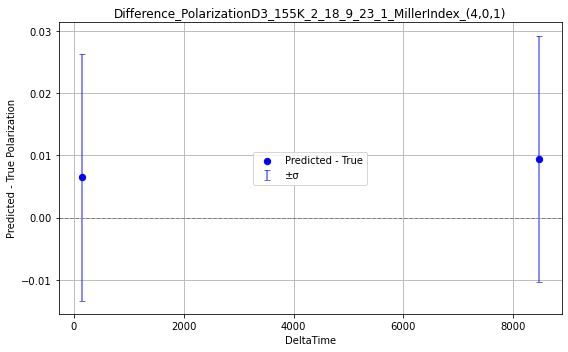

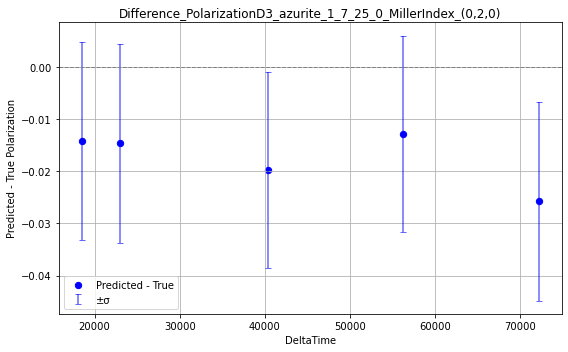

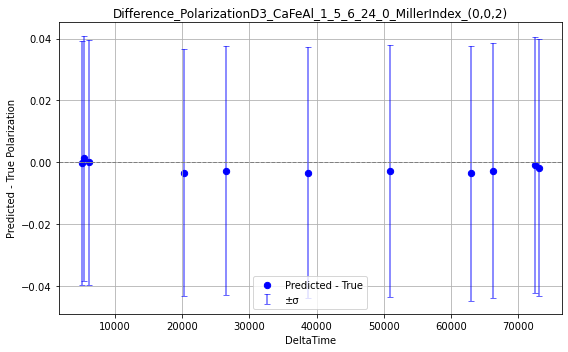

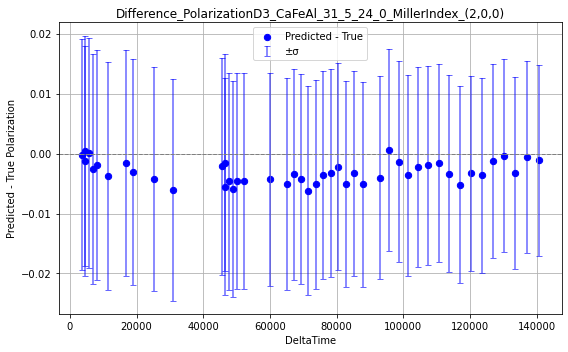

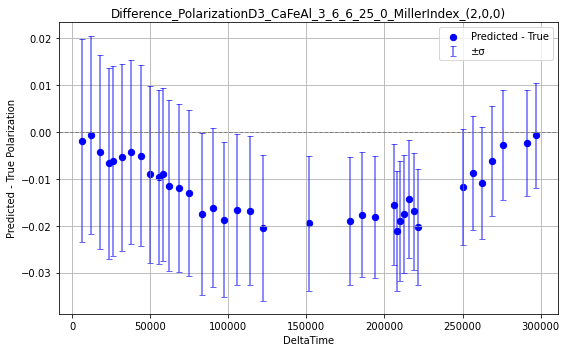

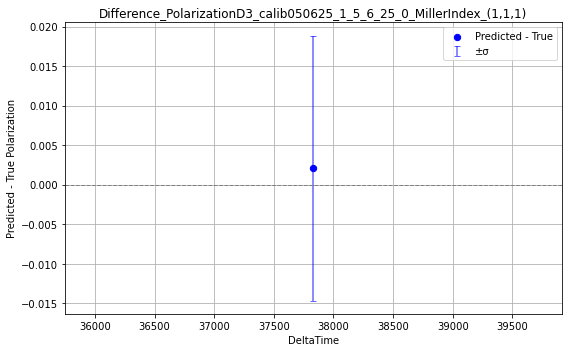

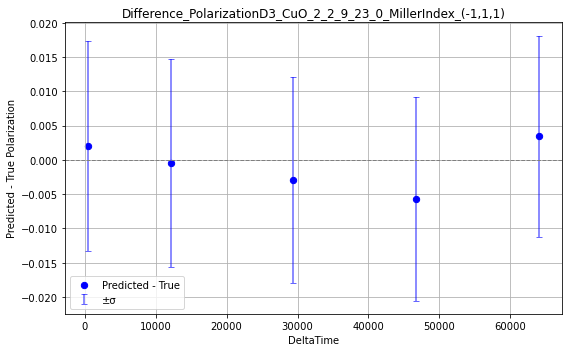

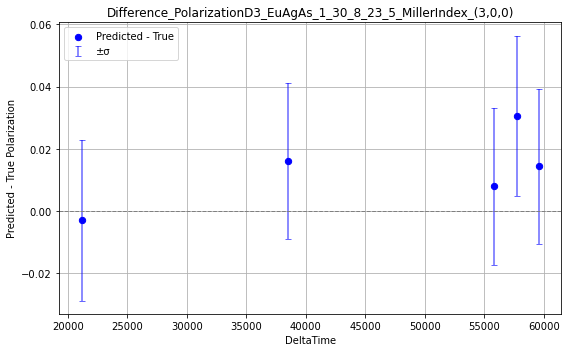

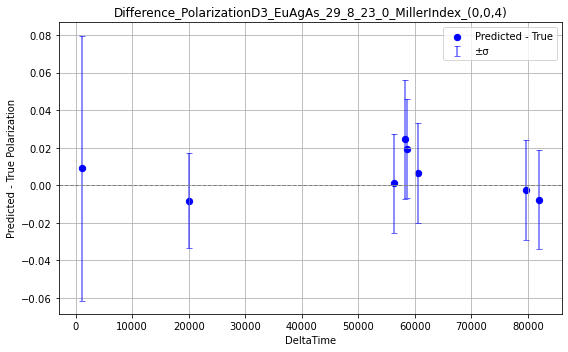

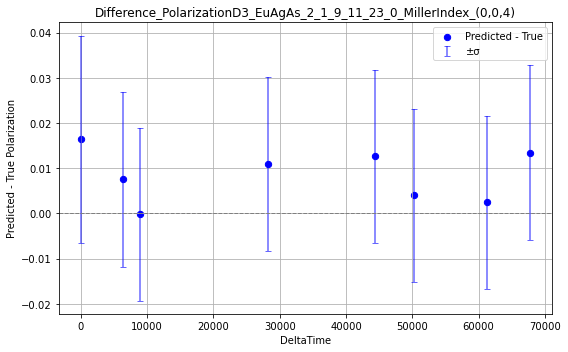

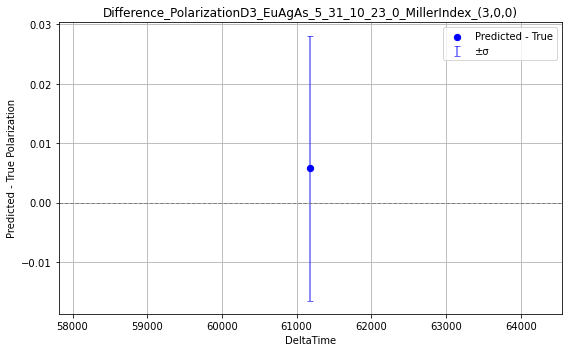

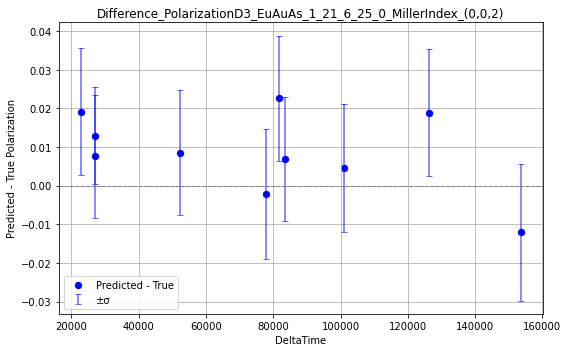

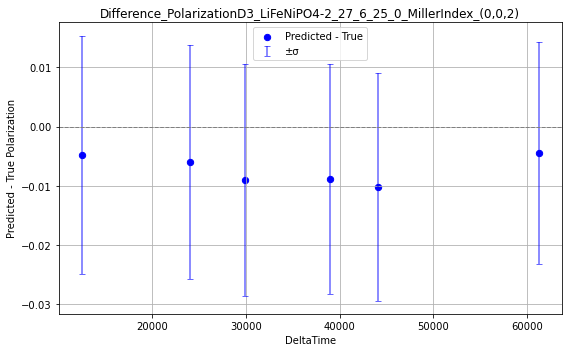

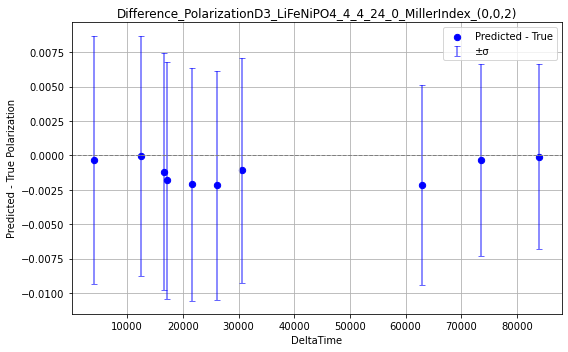

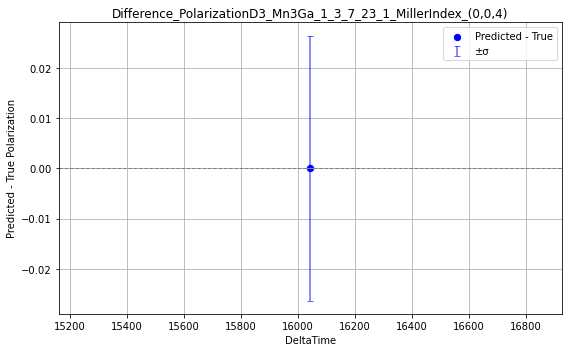

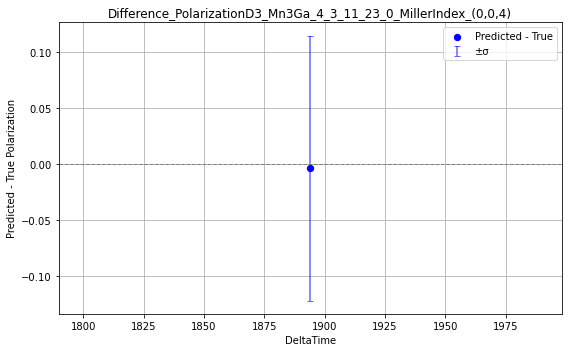

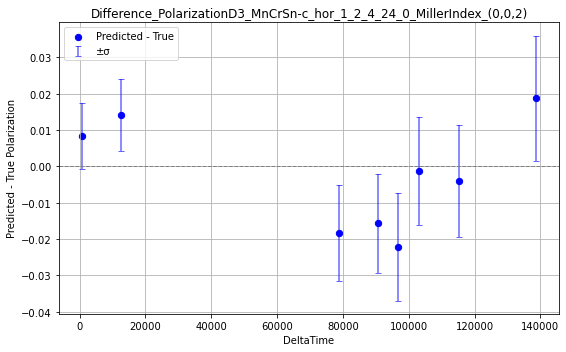

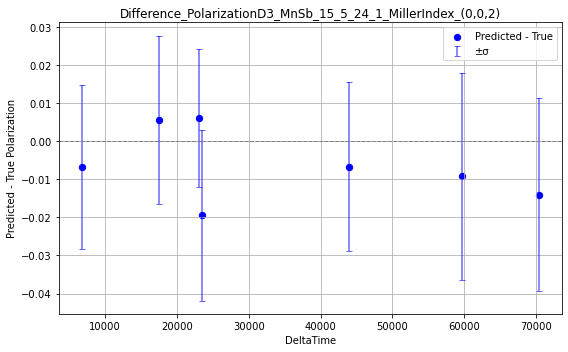

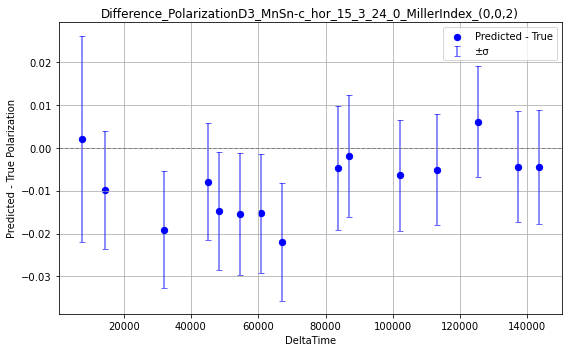

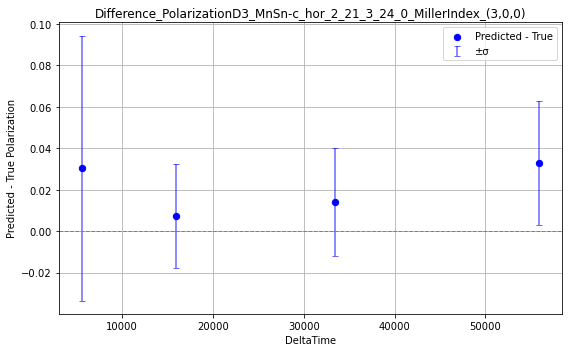

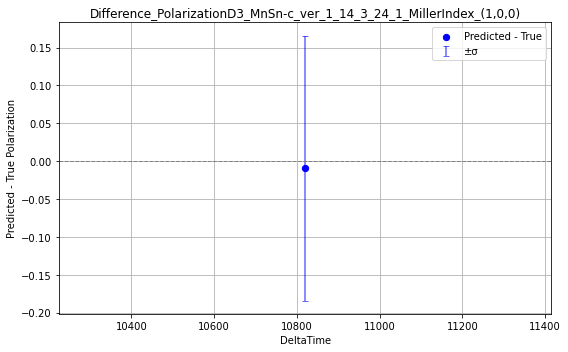

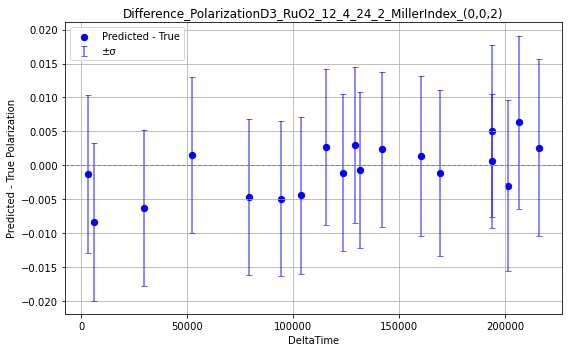

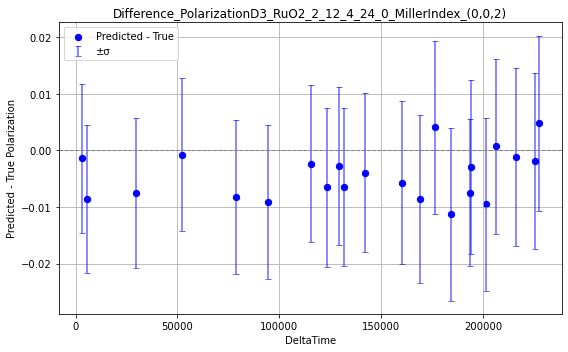

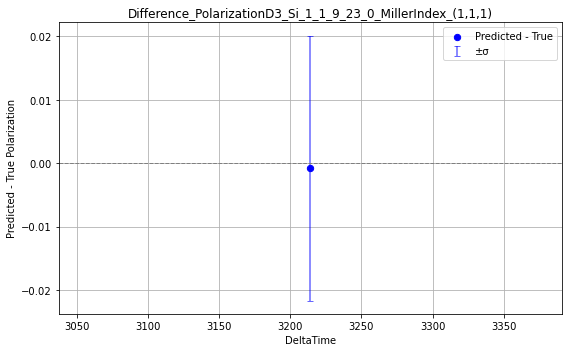

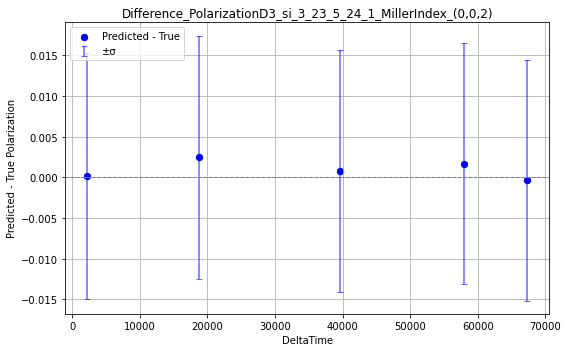

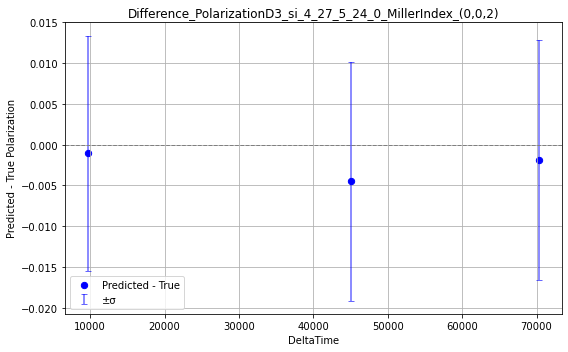

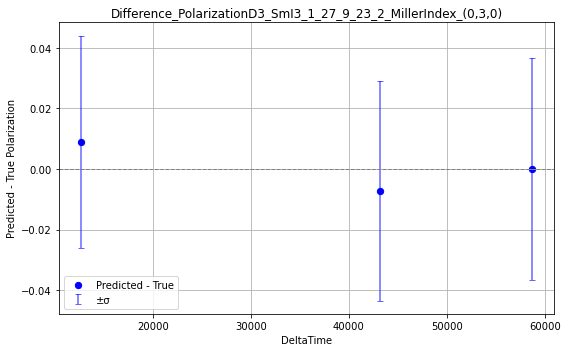

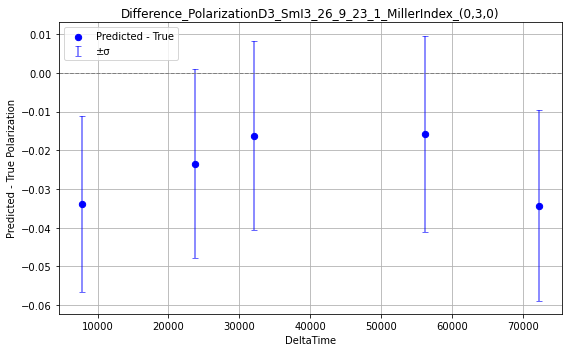

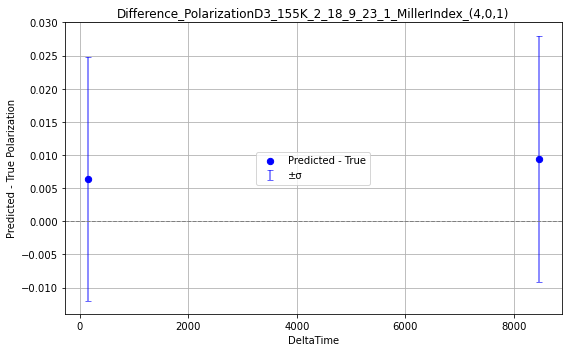

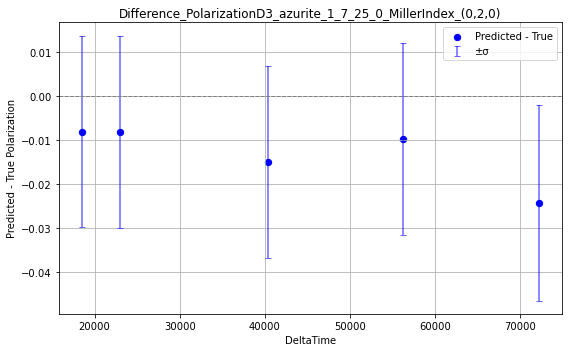

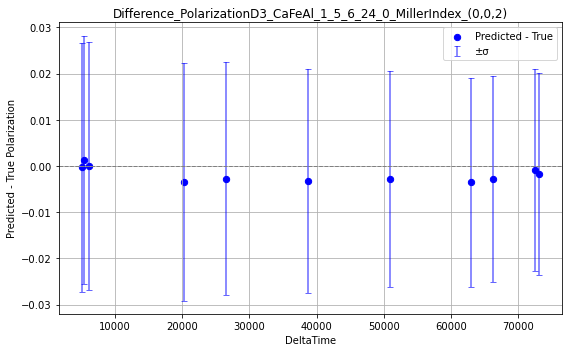

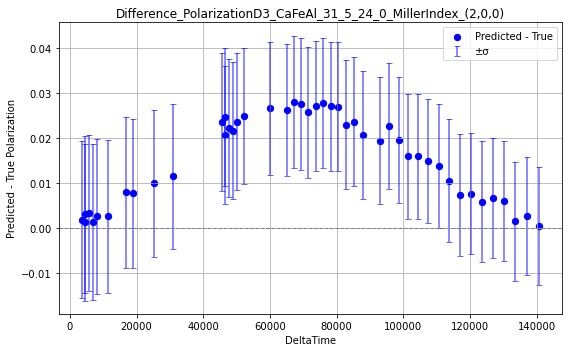

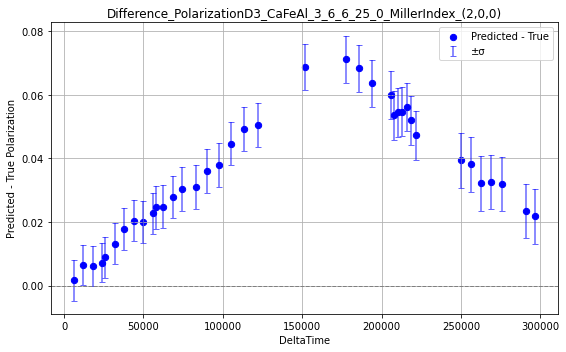

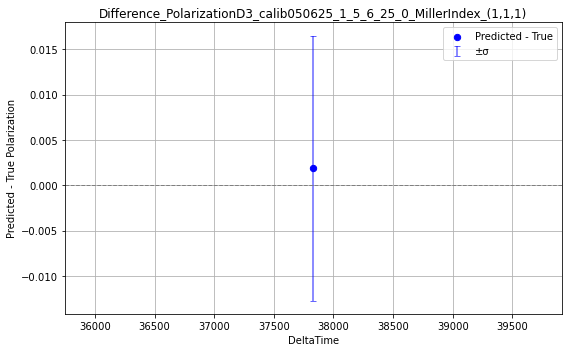

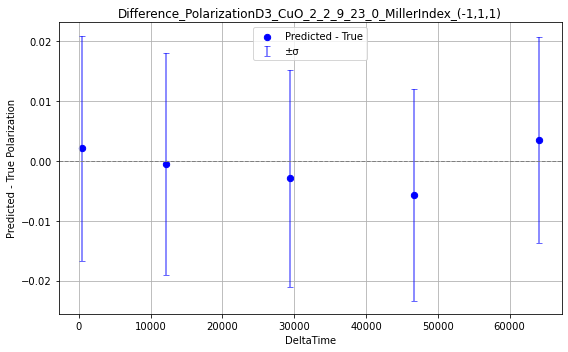

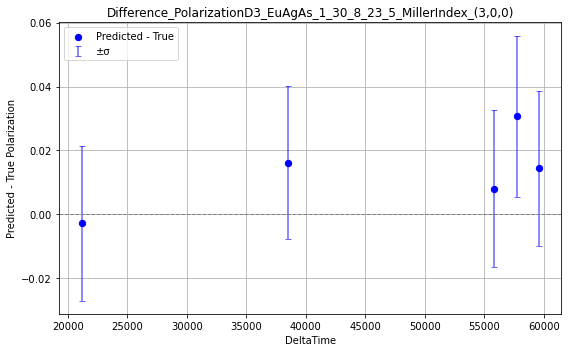

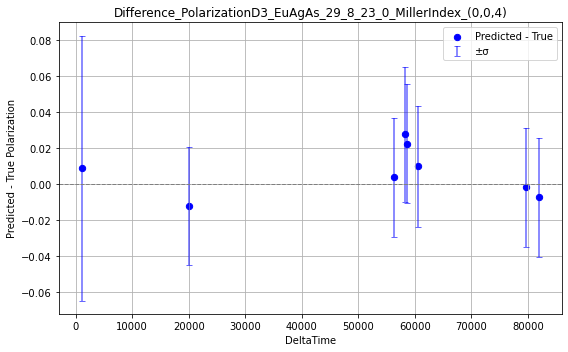

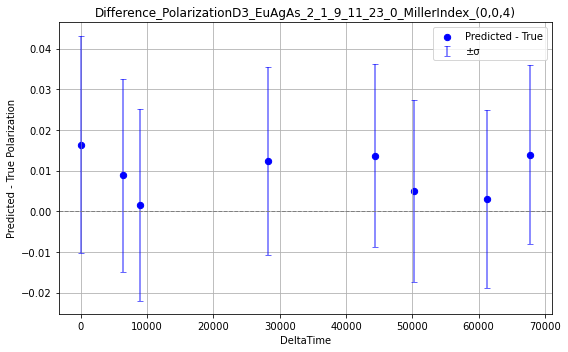

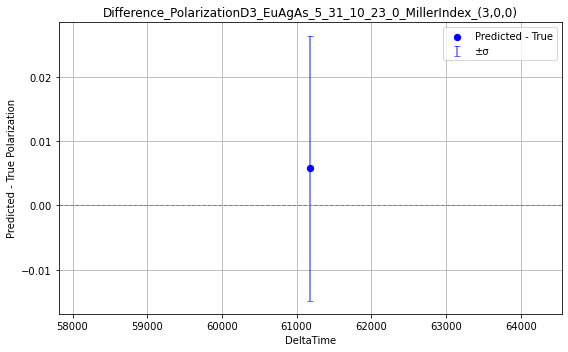

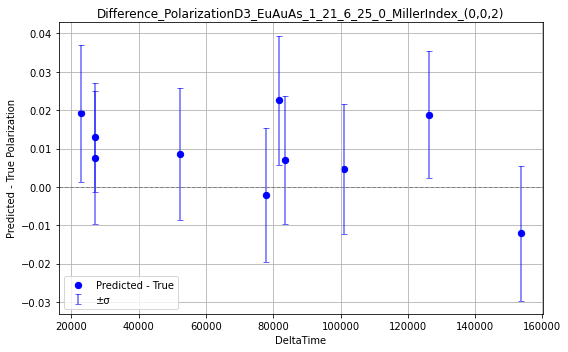

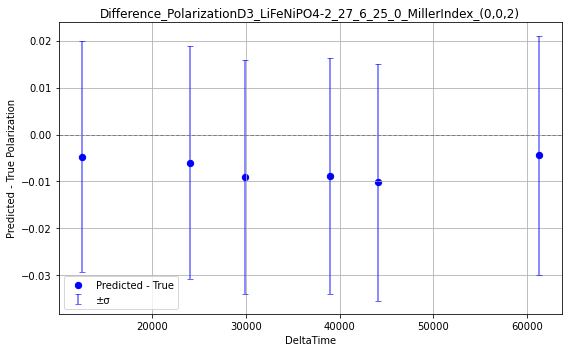

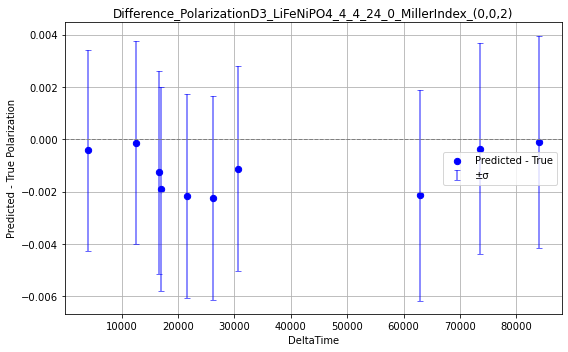

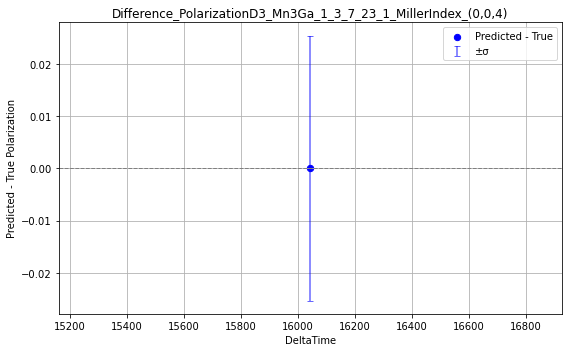

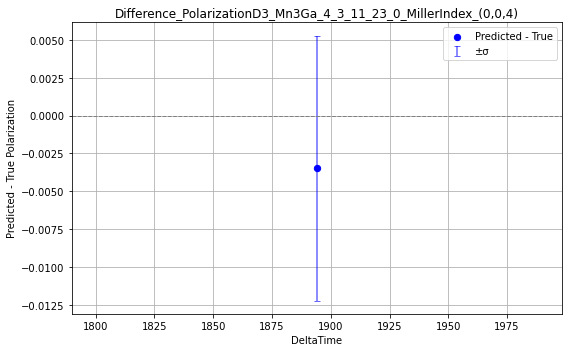

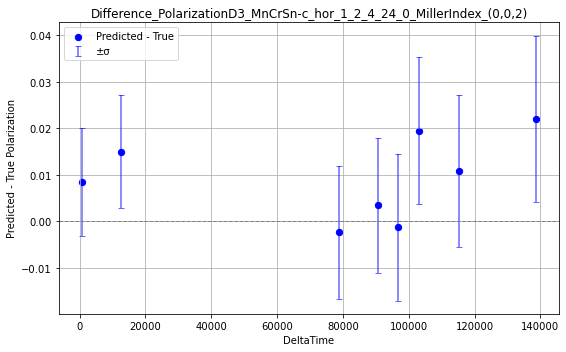

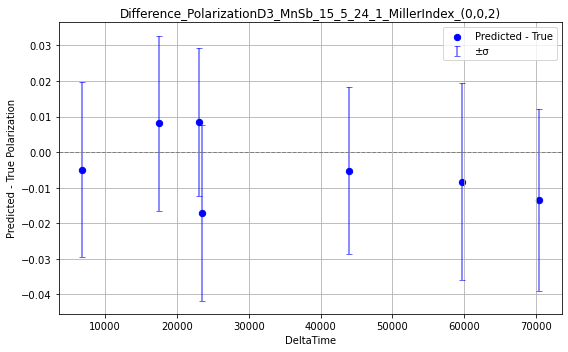

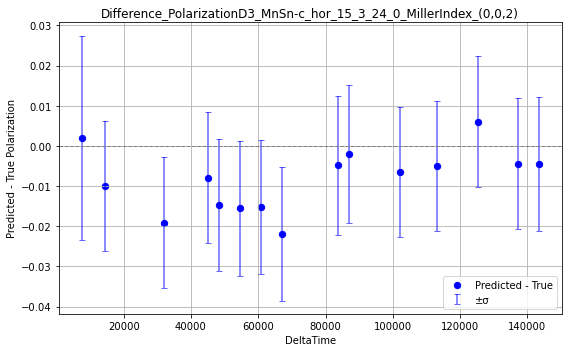

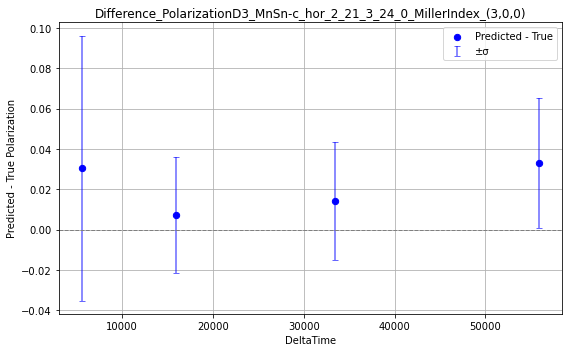

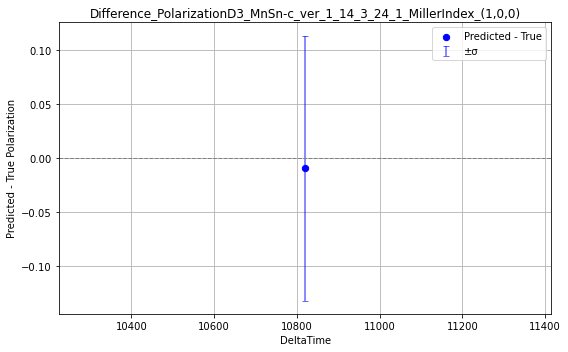

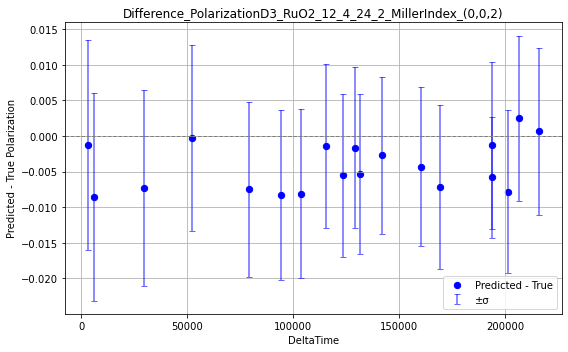

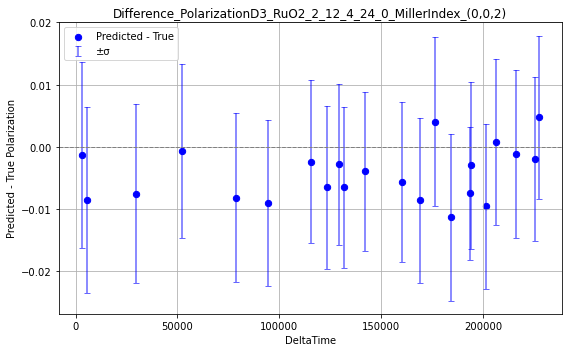

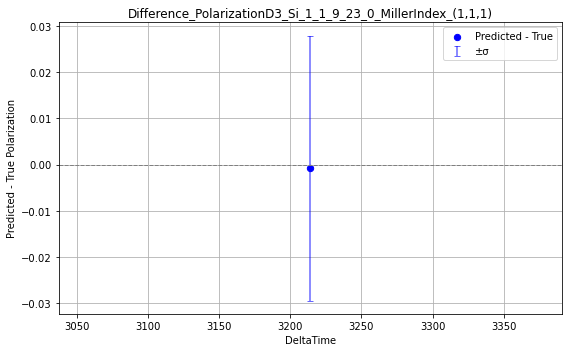

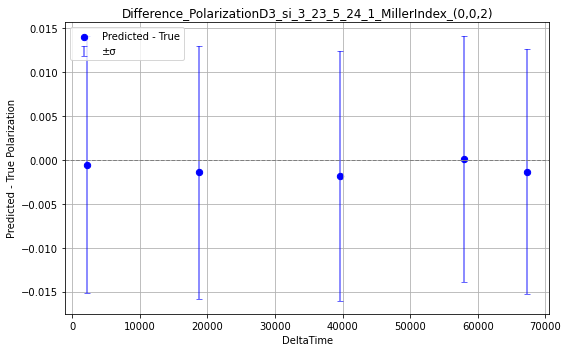

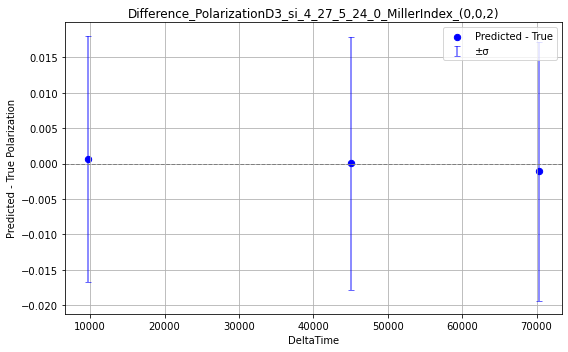

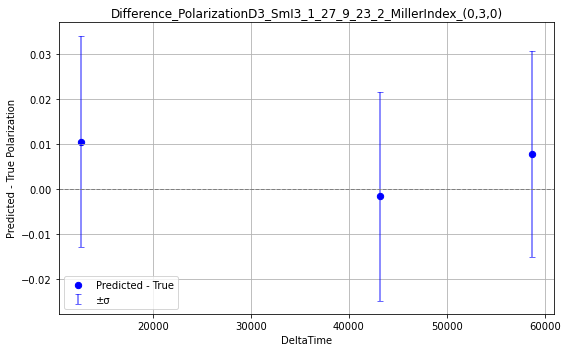

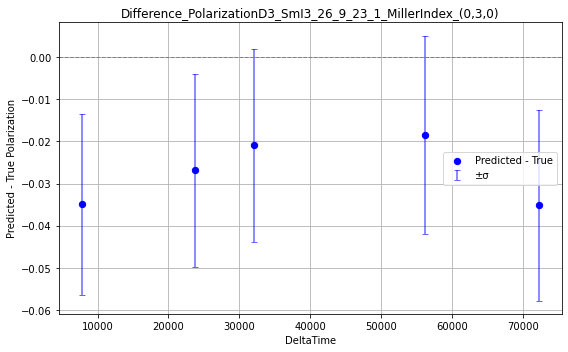

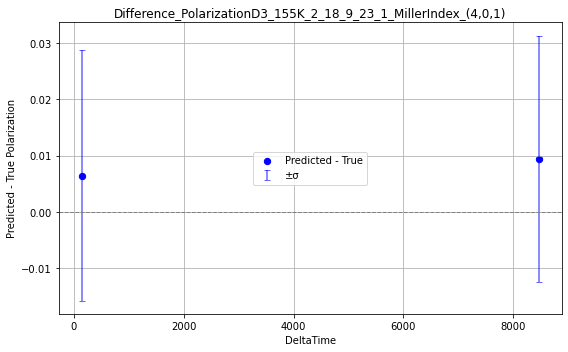

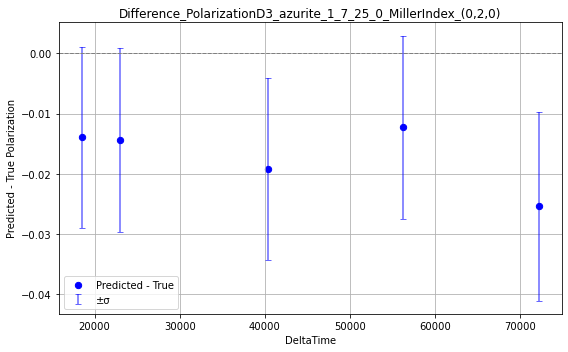

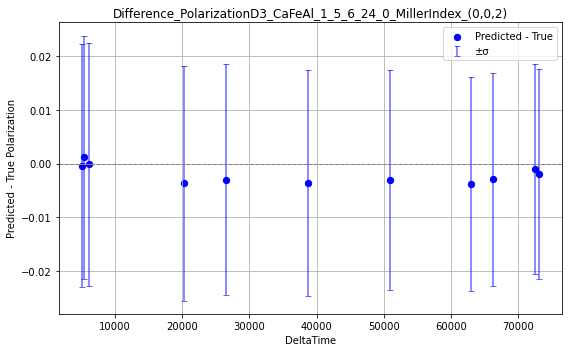

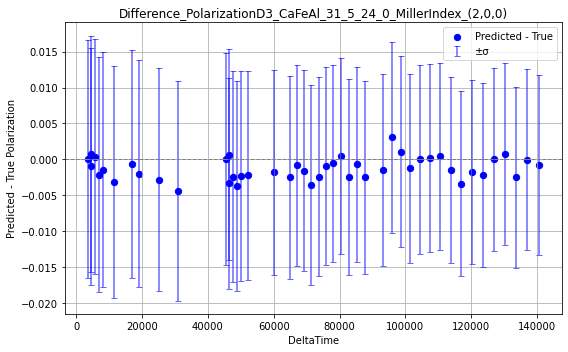

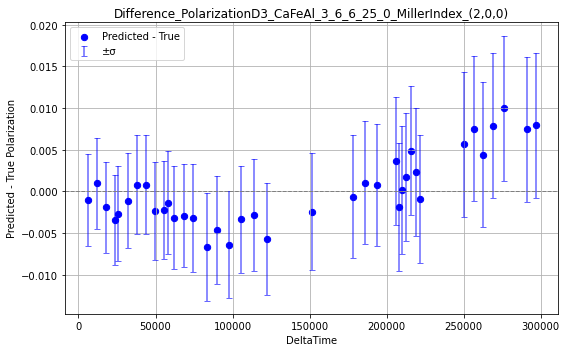

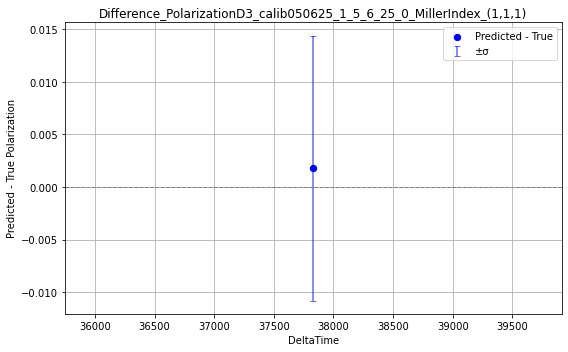

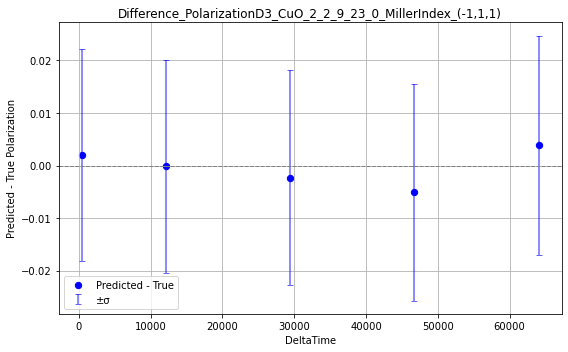

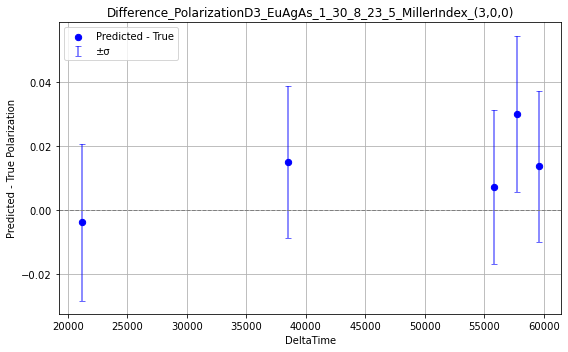

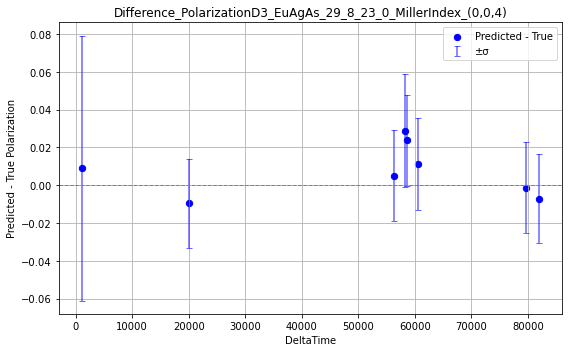

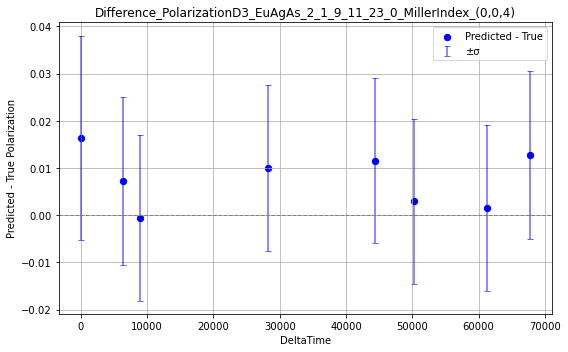

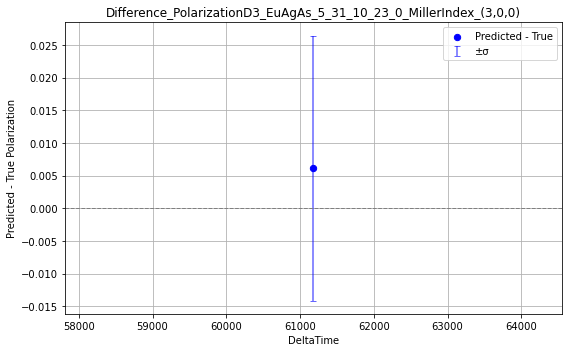

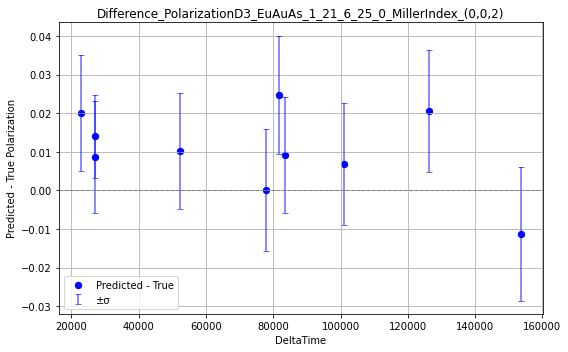

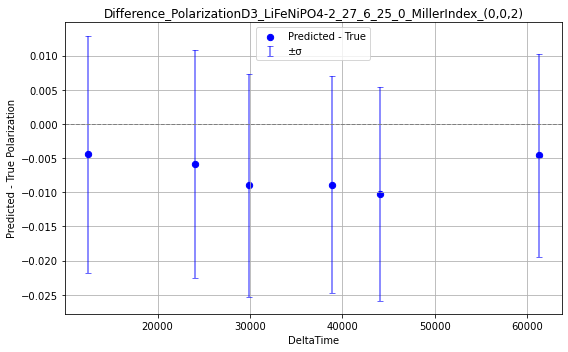

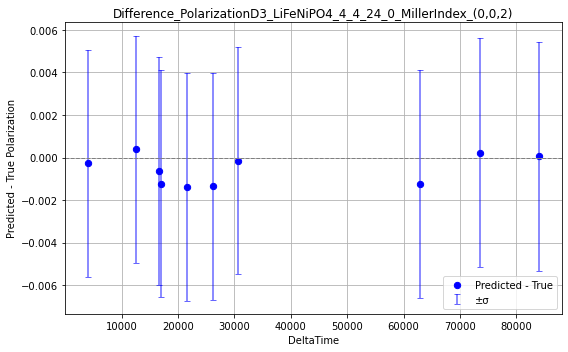

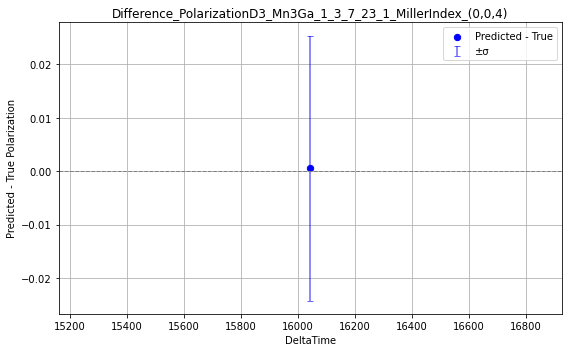

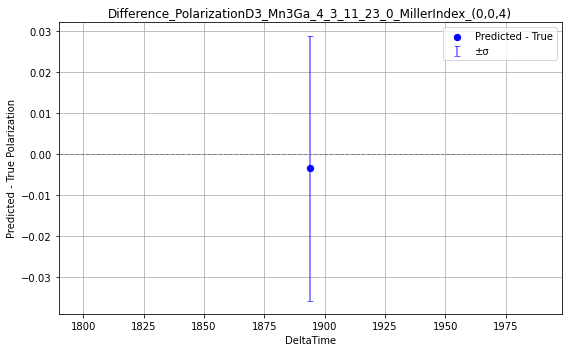

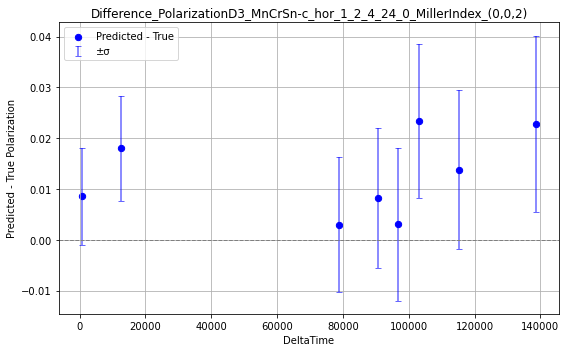

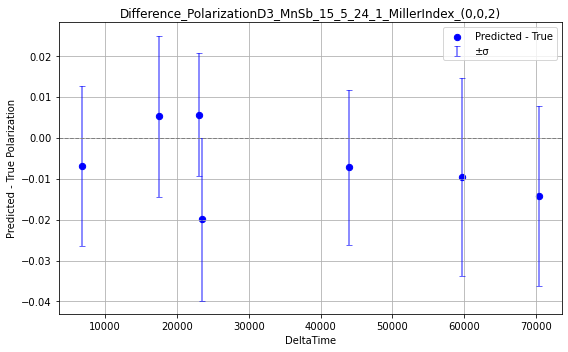

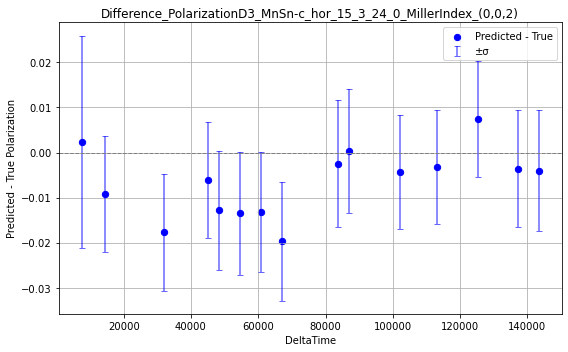

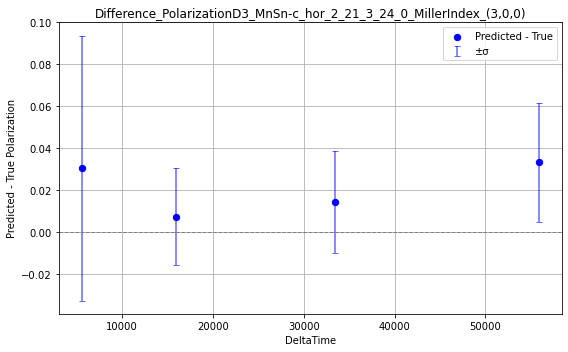

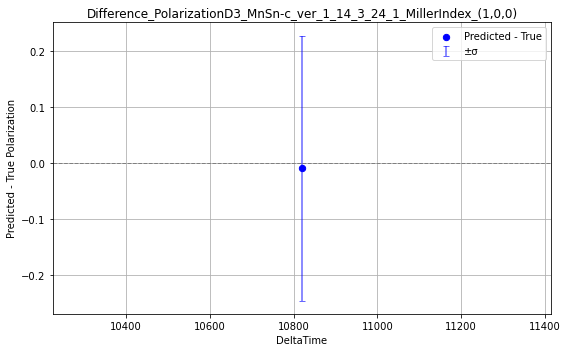

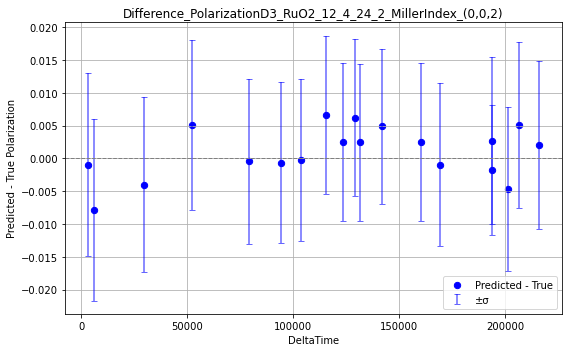

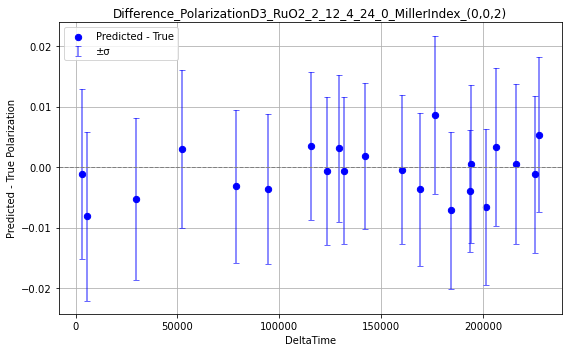

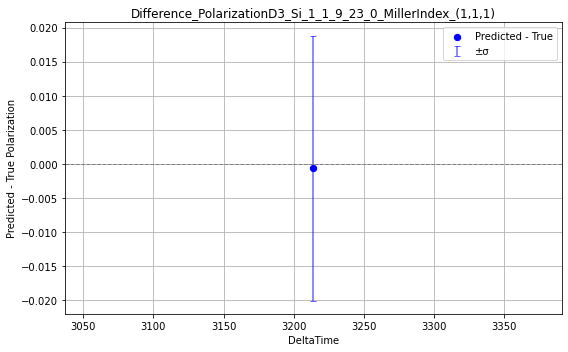

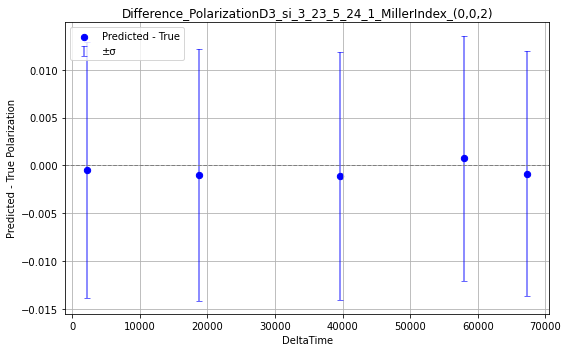

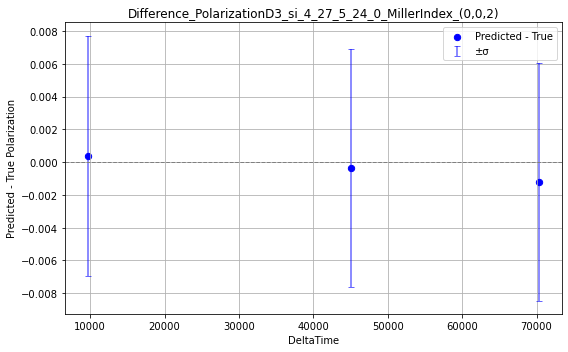

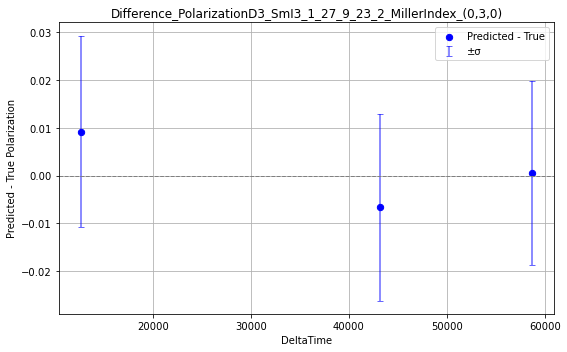

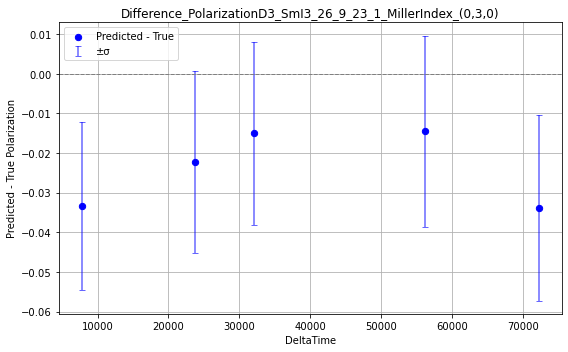

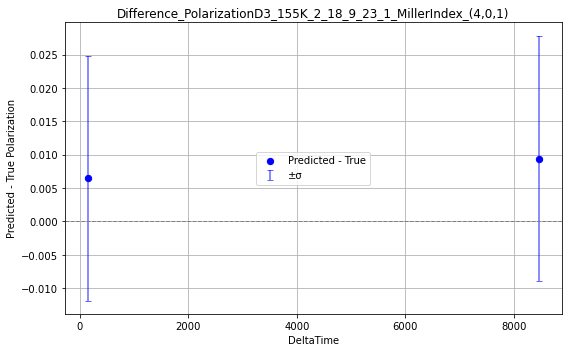

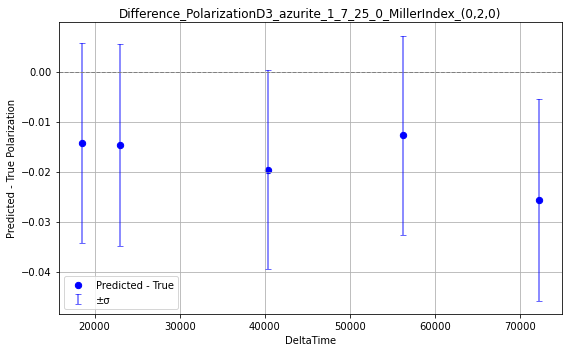

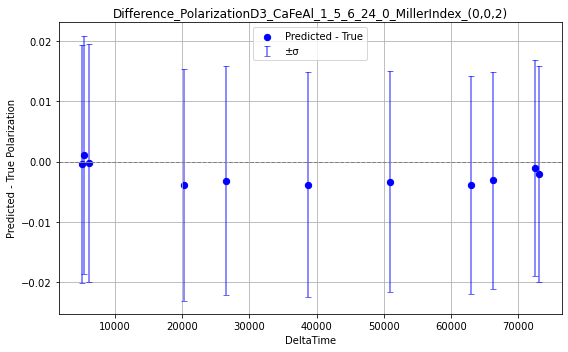

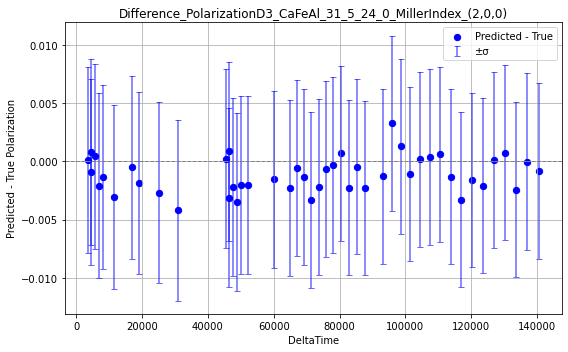

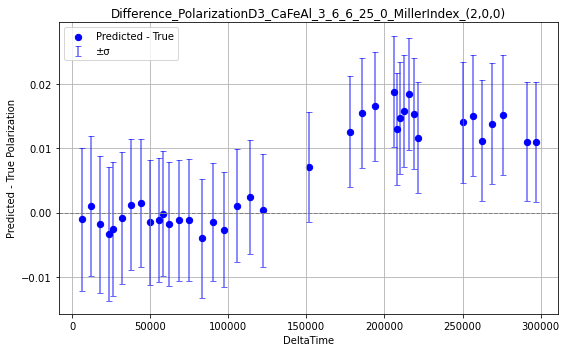

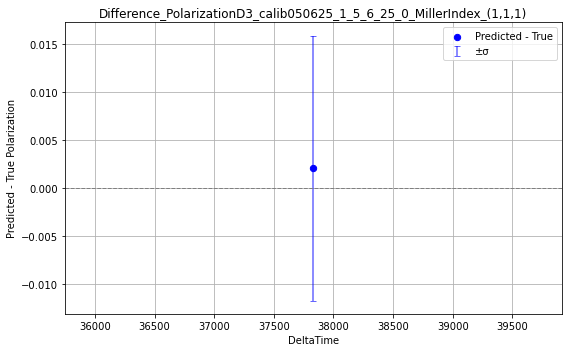

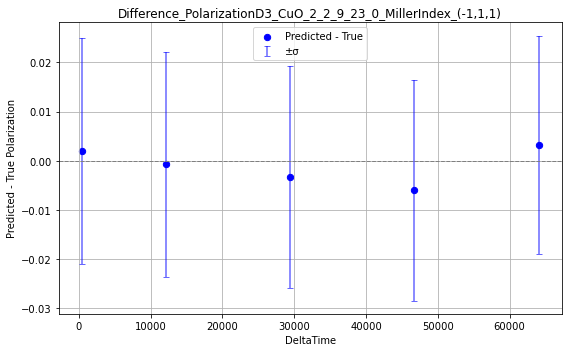

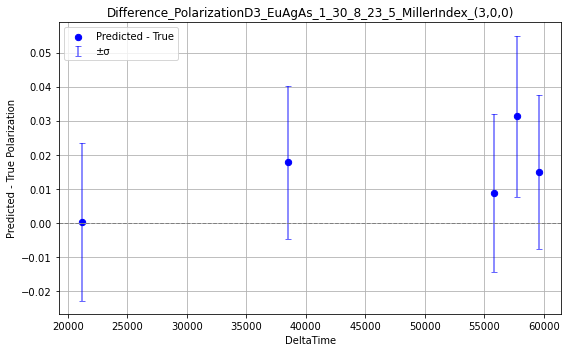

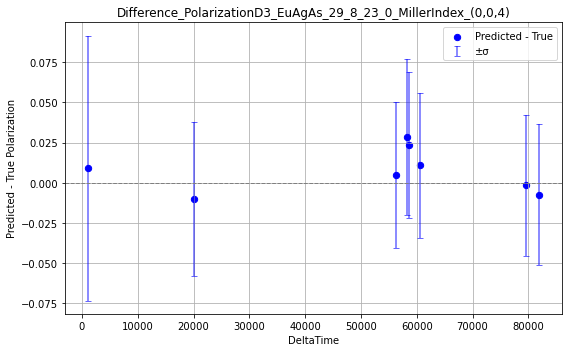

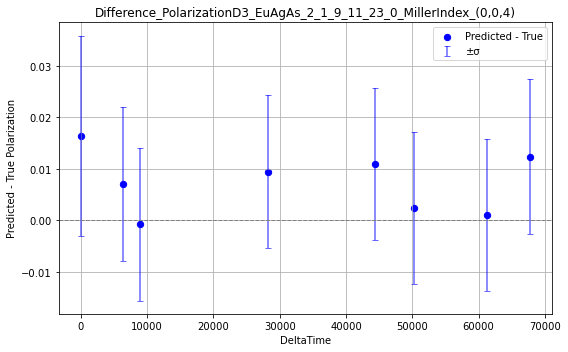

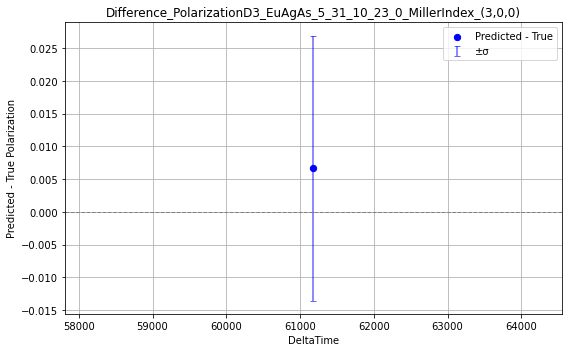

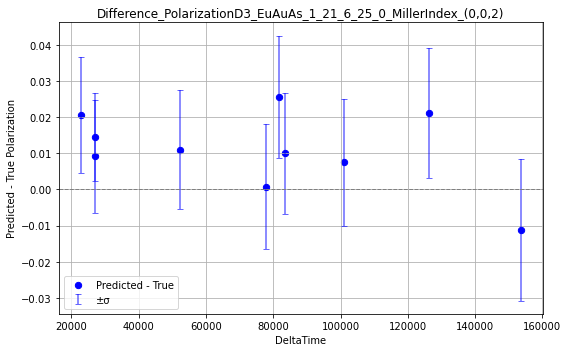

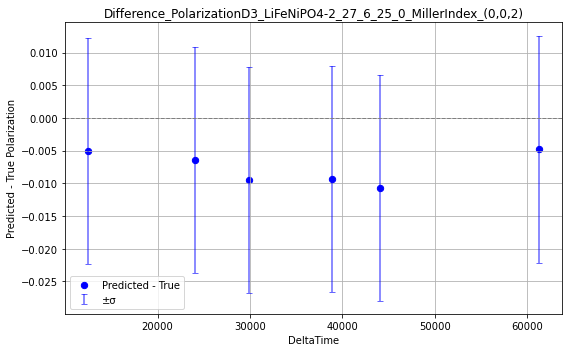

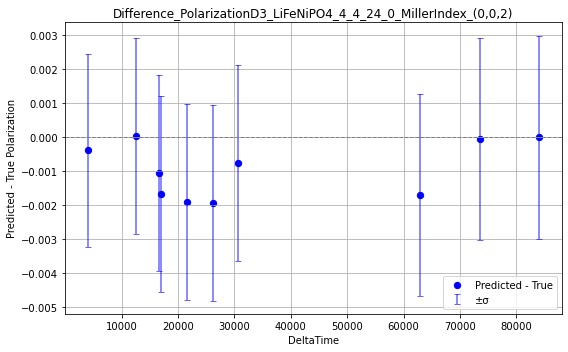

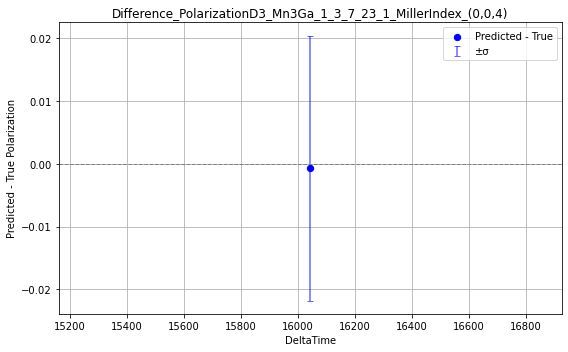

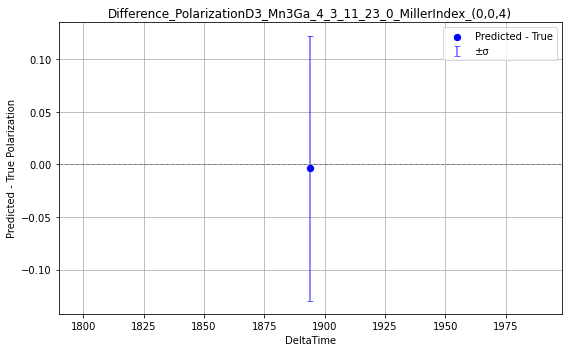

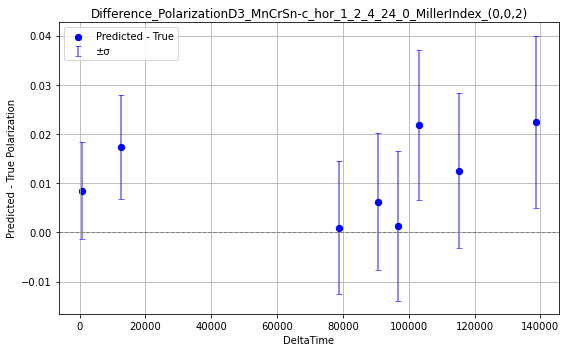

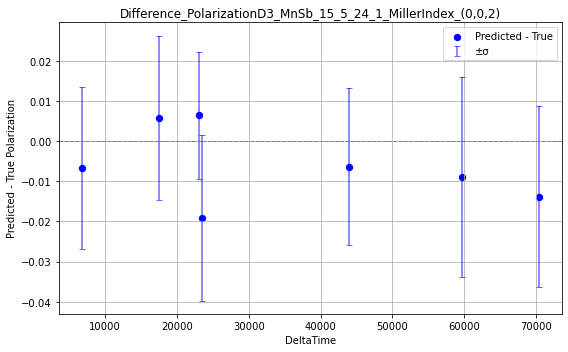

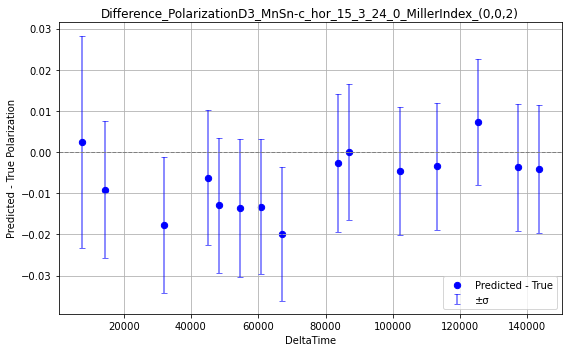

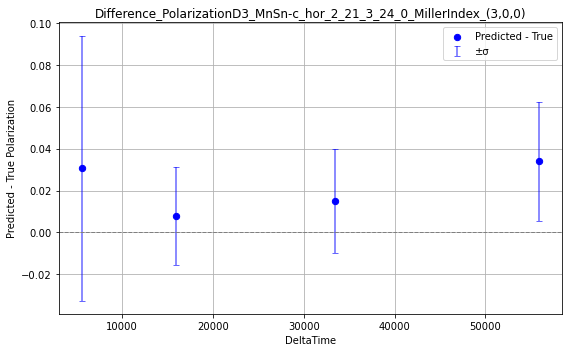

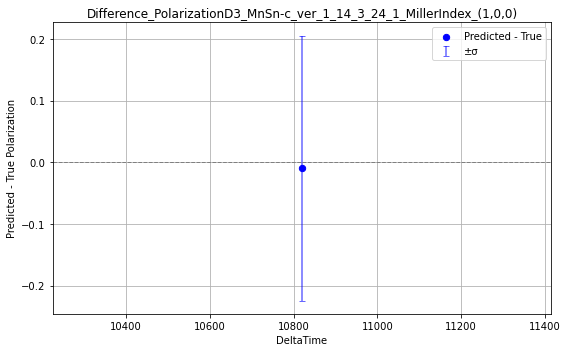

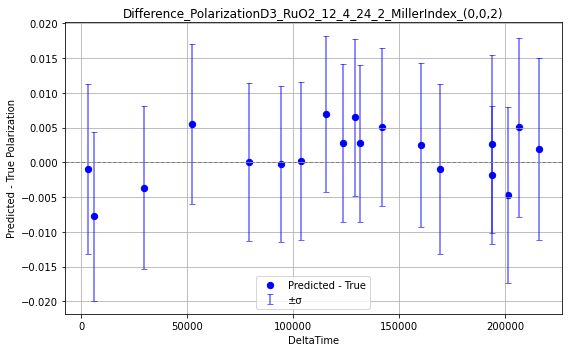

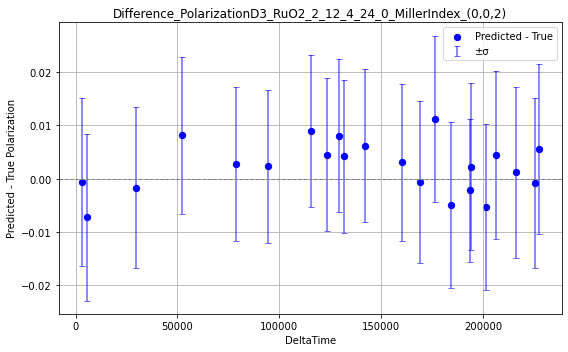

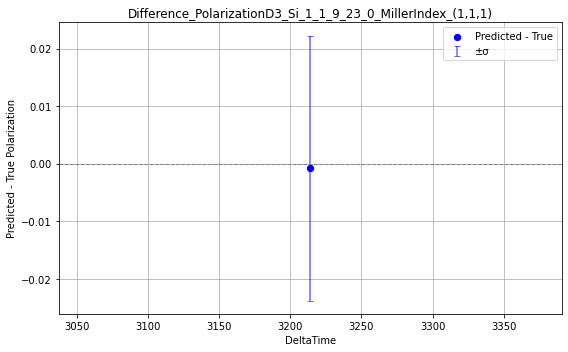

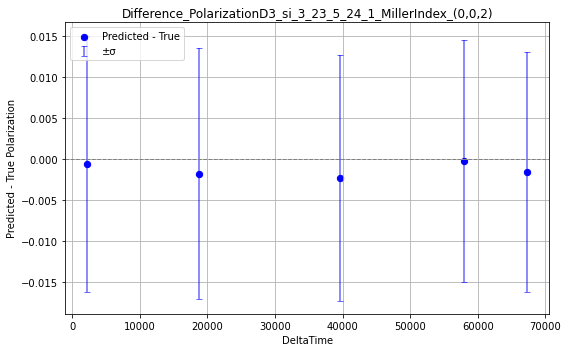

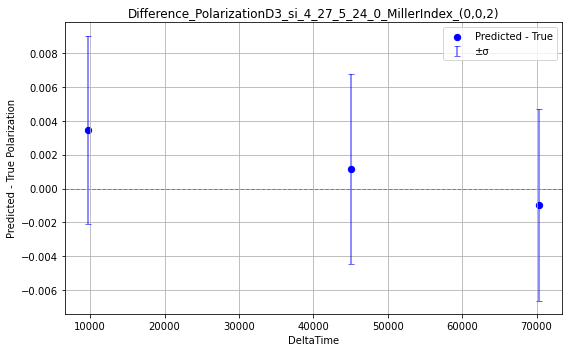

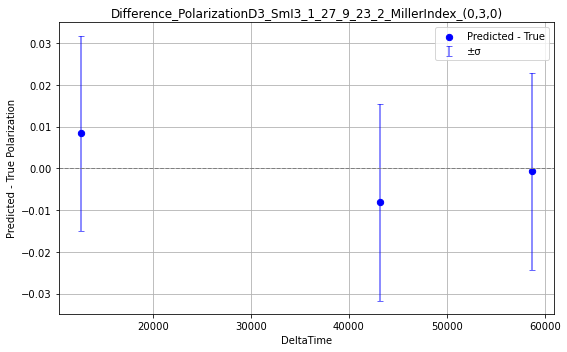

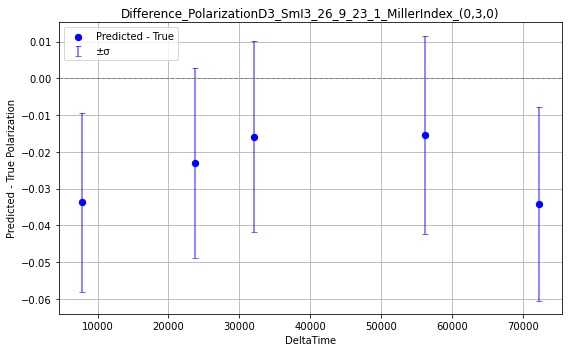

In [7]:
for Complexity in ["Naif", "Average"]:  # Desired complexity
    build_model = Define_Complexity(Complexity)
    for num_augmentations in [1,2]:  # Augmentations
        log_message(f"Begin {Complexity} model with {num_augmentations} augmentations")

        # Move all files back
        for file_path in isolated_dir.iterdir():  # iterates Path objects
            if file_path.is_file():  # only move files
                dst = data_dir / file_path.name
                shutil.move(win_long_path(file_path), win_long_path(dst))
                log_message(f"Moved {file_path.name} back to {data_dir}")

        # Path to the log file
        log_file = Path("CrystallineExecution_time.txt")
        os.makedirs(win_long_path(log_file.parent), exist_ok=True)

        # Start timing
        start_time = time.time()
        folder_to_delete = Path(f"CrystallineAllTestsFolder_{Complexity}_{num_augmentations}").resolve()
        if folder_to_delete.exists() and folder_to_delete.is_dir():
            shutil.rmtree(win_long_path(folder_to_delete))
            log_message(f"Deleted folder: {folder_to_delete}")
        else:
            log_message(f"Folder does not exist: {folder_to_delete}")

        # Recreate output folder
        output_folder = Path(f"CrystallineAllTestsFolder_{Complexity}_{num_augmentations}").resolve()
        os.makedirs(win_long_path(output_folder), exist_ok=True)

        # Run main function
        use_uncertainty = True
        Correction = True
        isolate_experiments(
            data_dir=win_long_path(data_dir),
            isolated_dir=win_long_path(isolated_dir),
            model_type=model_type,
            output_folder=win_long_path(output_folder),
            use_uncertainty=use_uncertainty,
            num_augmentations=num_augmentations,
            Correction=Correction,
            build_model=build_model
        )

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Write to log file safely with long path
        with open(win_long_path(str(log_file)), "a") as f:
            f.write(f"Execution time={elapsed_time:.6f} seconds for Crystal {Complexity} {num_augmentations}\n")

        log_message(
            f"Execution finished in {elapsed_time:.6f} seconds "
            f"(Complexity={Complexity}, Augmentations={num_augmentations}). "
            f"Logged to {log_file}"
        )
        log_message(f"\n _______________________________________________________ \n")